<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/model%20layers%20pop/cosin%20dist/%20orth/TEST%205%20_cosian_dist_orth_best%20model_%2016%20outer%20shift_480%20spw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
subject number = 109 >> 90 train subject  + 19 new subject 
channel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]

model3 -  1 layer pop

** subjects  (train subject (ts) , new subject (ns) ):

1) Train subject i (ts[i] )
2) Train Subject i and Train Subject j (ts[i] , ts[j] )
3) Train subject and New subject  (ts , ns)
4) New subject i ( ns[i] )
5) New Subject i and New Subject j (ns[i] , ns[j] )

'''


'\nsubject number = 109 >> 90 train subject  + 19 new subject \nchannel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]\n\nmodel3 -  1 layer pop\n\n** subjects  (train subject (ts) , new subject (ns) ):\n\n1) Train subject i (ts[i] )\n2) Train Subject i and Train Subject j (ts[i] , ts[j] )\n3) Train subject and New subject  (ts , ns)\n4) New subject i ( ns[i] )\n5) New Subject i and New Subject j (ns[i] , ns[j] )\n\n'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mne

In [0]:
'''
Rivision:
980806:
  First version.
  
  

'''

'\nRivision:\n980806:\n  First version.\n  \n  \n\n'

In [0]:
# Parameters:

EpochNum=60
subject_numberT=109
RemoveBaseLine=0
Orthogonal=1
task_index = [1] # task: REO
list_channel=[61,40,10]
TryStr='Try1'
seed = 14

task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =8  # outer step len
sample_per_window = 960
window_len= 20
batch_size=64

#Search_Space_Channel = [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
#Search_Space_Channel_Name=["Fp1","Fp2","F7","F3","Fz","F4","F8","T7","C3","Cz","C4","T8","P7","P3","Pz","P4","P8","O1","Oz","O2"]


In [17]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
from shapely.geometry import LineString



# General use
import itertools
from itertools import combinations 

import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime
import statistics

# General use
import itertools
from itertools import combinations 
import statistics
import csv
import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime


# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Automatically created module for IPython interactive environment


In [0]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_numberT
for x in range(subject_numberT):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_numberT,task_number), dtype='object')

for i in range(subject_numberT):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


In [102]:
subject_number = 90
# new subject
new_subject =np.arange(subject_number, subject_numberT)

# img for each subject
subject_img_number = math.floor((total_sampel_number - sample_per_window - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1
np.random.seed(seed)  

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

subject_img_number_array_shuffled=np.arange(subject_img_number)
np.random.shuffle(subject_img_number_array_shuffled)

train_index = math.floor(len(subject_img_number_array_shuffled)* 0.75)
val_index = train_index + (train_index//5)

train_shuff = subject_img_number_array_shuffled[:train_index]
val_shuff = subject_img_number_array_shuffled[train_index:val_index]
test_shuff = subject_img_number_array_shuffled[val_index:]


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)
subject_img_number

1071

In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,OrthogonalFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    #ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][0][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    e= 0    
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][0][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        
        for i in range(len(ListChannel)):
            DataChannelsRaw[e][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[e][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[e][i])) # min for each cannel

            DataChannelsNormal[e][i]=normalize_channel_data(DataChannelsRaw[e][i].copy(), i, ch_min, ch_max)
        

        # Orthogonal Channel
        DataChannelsOrt[e][0]=DataChannelsNormal[e][0]
        DataChannelsOrt[e][1]=DataChannelsNormal[e][1]-ProjectionVector(DataChannelsOrt[e][0].copy(),DataChannelsNormal[e][1].copy())*OrthogonalFlag
        DataChannelsOrt[e][2]=DataChannelsNormal[e][2]-ProjectionVector(DataChannelsOrt[e][0].copy(),DataChannelsNormal[e][2].copy())*OrthogonalFlag\
                                                      -ProjectionVector(DataChannelsOrt[e][1].copy(),DataChannelsNormal[e][2].copy())*OrthogonalFlag

        e = e+1
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          r = 0
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, sample_per_window), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsOrt[r][i][0+j*OuterSampleShift + z*InnerSampleShift:sample_per_window+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data
              r=r+1

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,subject_numberT)
                TI = np.moveaxis(TrainImage, 1, -1)
                yield TI, TrainLabelClass 

                

In [0]:
ch_number=len(list_channel)
list_rawdataTemp=list_rawdata.copy()


In [0]:
# Construct Data Generator

GenTrainData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled=subject_number_array_shuffled,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled=train_shuff)

GenValidationData =GenerateGeneralData(BatchSize=batch_size,
                                        ListRawDataMain=list_rawdataTemp.copy(),
                                        SubjectArrayShuffled=subject_number_array_shuffled,
                                        ListChannel=list_channel,
                                        RemoveBaseLineFlag=RemoveBaseLine,
                                        OrthogonalFlag=Orthogonal,
                                        WindowLen=window_len,
                                        OuterSampleShift=outer_sample_shift,
                                        InnerSampleShift=inner_sample_shift,
                                        SampelNumberPerSec=sampel_number_per_sec,
                                        ImageArrayShuffled=val_shuff)

GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                ListRawDataMain=list_rawdataTemp.copy(),
                                SubjectArrayShuffled=subject_number_array_shuffled,
                                ListChannel=list_channel,
                                RemoveBaseLineFlag=RemoveBaseLine,
                                OrthogonalFlag=Orthogonal,
                                WindowLen=window_len,
                                OuterSampleShift=outer_sample_shift,
                                InnerSampleShift=inner_sample_shift,
                                SampelNumberPerSec=sampel_number_per_sec,
                                ImageArrayShuffled=test_shuff)

In [0]:


#################################################################################################
# Create Model
model = models.Sequential()
model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding='same', input_shape = (window_len,sample_per_window,ch_number) ))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(512, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(subject_numberT, activation = 'softmax'))

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])

#################################################################################################
filepath = '/content/drive/My Drive/mymodels/bestmodel_point_8os_960spw.h5'
#earlystopping_callback = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0,patience=10,mode='auto', restore_best_weights=True)
ModelCheckpoint_callbacks = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='auto', period=1)
# Train the Model
history = model.fit_generator(epochs =30,
                              generator=GenTrainData,
                              steps_per_epoch=np.ceil(train_number*subject_number/batch_size),
                              callbacks=[ModelCheckpoint_callbacks],
                              validation_data=GenValidationData,
                              validation_steps =np.ceil(val_number*subject_number/batch_size),
                              use_multiprocessing=False,
                              workers=1)

#################################################################################################
# Evalute the Model
TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
print('     TrainResult ([loss , acc])=',TrainResult)
print('ValidationResult ([loss , acc])=',ValidationResult)
print('      TestResult ([loss , acc])=',TestResult)

#################################################################################################
# plot accuracy
history_dict = history.history 
acc_values = history_dict ['acc'] 
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)


#plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation acc') 
plt.xlabel('Epochs') 
plt.ylabel('acc') 
plt.legend()
plt.show()

history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.show()

Epoch 1/30
1130/1130 [==============================] - 148s 131ms/step - loss: 2.1379 - acc: 0.4011 - val_loss: 0.5794 - val_acc: 0.8466
Epoch 2/30
1130/1130 [==============================] - 145s 128ms/step - loss: 0.4414 - acc: 0.8568 - val_loss: 0.0842 - val_acc: 0.9803
Epoch 3/30
1130/1130 [==============================] - 145s 128ms/step - loss: 0.1291 - acc: 0.9592 - val_loss: 0.0144 - val_acc: 0.9976
Epoch 4/30
1130/1130 [==============================] - 145s 128ms/step - loss: 0.0557 - acc: 0.9835 - val_loss: 0.0024 - val_acc: 0.9996
Epoch 5/30
1130/1130 [==============================] - 144s 128ms/step - loss: 0.0334 - acc: 0.9903 - val_loss: 9.9964e-04 - val_acc: 0.9999
Epoch 6/30
1130/1130 [==============================] - 145s 128ms/step - loss: 0.0246 - acc: 0.9929 - val_loss: 0.0019 - val_acc: 0.9994
Epoch 7/30
1130/1130 [==============================] - 145s 128ms/step - loss: 0.0190 - acc: 0.9946 - val_loss: 9.4384e-05 - val_acc: 1.0000
Epoch 8/30
1130/1130 [====

In [0]:
#model.save('/content/drive/My Drive/mymodels/finalmodel_orth_Oz_T7_C3.h5')

In [19]:
model = load_model('/content/drive/My Drive/mymodels/bestmodel_point_8os_960spw.h5')
model.summary()
model.pop()
model.pop()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 20, 480, 128)      3584      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 240, 128)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 238, 256)       295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 119, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 117, 512)       1180160   
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 58, 512)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 29696)            

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [18]:
# Evalute the Model
TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
print('     TrainResult ([loss , acc])=',TrainResult)
print('ValidationResult ([loss , acc])=',ValidationResult)
print('      TestResult ([loss , acc])=',TestResult)

#################################################################################################
# plot accuracy
history_dict = history.history 
acc_values = history_dict ['acc'] 
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)


#plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation acc') 
plt.xlabel('Epochs') 
plt.ylabel('acc') 
plt.legend()
plt.show()

history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.show()

     TrainResult ([loss , acc])= [0.00021464685019897148, 1.0]
ValidationResult ([loss , acc])= [0.00030642832979454, 1.0]
      TestResult ([loss , acc])= [0.0003060507915167663, 1.0]


NameError: ignored

In [0]:
def subject_Predict_generator(batch_size, mymodel, subject_arr, img_arr ):
  sn = len(subject_arr)
  imgn = len(img_arr)
  pre_GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled= subject_arr,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled= img_arr)

  pre_Subject = mymodel.predict_generator(pre_GenTestData,steps=np.ceil(imgn*sn/batch_size))
  return pre_Subject


total_vector=[]
subject_img_idx_array = np.arange(subject_img_number)

for i in range(109):
  Si_vectors = subject_Predict_generator(len(subject_img_idx_array), model, [i], subject_img_idx_array)
  total_vector.append(Si_vectors)

In [82]:
import h5py
#hf = h5py.File('/content/drive/My Drive/mymodels/vectors/bestpointmodel_total_vectors_orth_Oz_T7_C3_480_spw_outrshift160.h5', 'w')
#hf.create_dataset('/content/drive/My Drive/mymodels/vectors/dataset_total_vectors', data=total_vector)
#hf.close()
hf = h5py.File('/content/drive/My Drive/mymodels/vectors/bestpointmodel_total_vectors_orth_Oz_T7_C3_480_spw_outrshift160.h5', 'r')
vec = hf.get('/content/drive/My Drive/mymodels/vectors/dataset_total_vectors')
vec


<HDF5 dataset "dataset_total_vectors": shape (109, 57, 1024), type "<f4">

In [0]:
import h5py
hf = h5py.File('/content/drive/My Drive/mymodels/vectors/bestpointmodel_total_vectors_orth_Oz_T7_C3_480_spw_outrshift8.h5', 'w')
hf.create_dataset('/content/drive/My Drive/mymodels/vectors/dataset_total_vectors', data=total_vector)
hf.close()
hf = h5py.File('/content/drive/My Drive/mymodels/vectors/bestpointmodel_total_vectors_orth_Oz_T7_C3_480_spw_outrshift8.h5', 'r')
vec = hf.get('/content/drive/My Drive/mymodels/vectors/dataset_total_vectors')
vec


In [62]:
a2 = np.arange(0,10)
a2

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [64]:
a2[-3:]

array([7, 8, 9])

In [0]:
### verification with middle of samples

def VerifySubject(threshold, s1, smp1, s2, smp2):
  list_d =[]

  for i in range(len(smp1)):
    #print(s1 ,vec1[i] )
    d= distance.cosine(vec[s1][smp1[i]], vec[s2][smp2[i]])
    list_d.append(d)
  midd = statistics.median_low(list_d)

  if (midd) <threshold :
    return 0 # same
  else:
    return 1 # different


In [73]:
from shapely.geometry import LineString

subject_img_number

1131

In [0]:
### generate data for verification
def counter_true_false_result(start_index_s1, end_index_s1 ,start_index_s2, end_index_s2 ):
  tryatr="try4_2000_160os_480spw_far"
  threshold = 0
  pair_number = 2000
  sample_img_num = 1
  Batch_size = 1
  ITER = pair_number //2


  path = "/content/drive/My Drive/Orth_cosian/"+tryatr+" best point model- cosian dist_true ORTH new model" +str(sample_img_num)+"sample num_"+str(pair_number)+"pair_"+ "ouer shift" + str(outer_sample_shift)

  try:
      os.mkdir(path)
  except OSError:
      print ("Creation of the directory %s failed" % path)
  else:
      print ("Successfully created the directory %s " % path)



  
  ## CSV file name 
  csvFileName =str(sample_img_num)+"sample num_"+str(pair_number)+"pair"+ "_MIDDLE threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".csv"
  completeName = os.path.join(path, csvFileName )

  png_FileName =str(sample_img_num)+"sample num_"+str(pair_number)+"pair"+ "_MIDDLE threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".png"
  png_completeName = os.path.join(path, png_FileName )

  list_threshold = []
  list_TP = []
  list_TN = []
  list_FP = []
  list_FN = []
  list_FRR = []
  list_FAR = []
  list_EER = []
  list_Correct_Verifi_Percentage = []
  list_threshold_result =[]


  for j in range(1,25):

      threshold =0.225+ (j*0.01)
      threshold = round(threshold,4)
      #threshold = j
      TP =0
      TN =0
      FP =0
      FN =0
      FAR =0
      FRR =0
      EER =0
      true_result= 0
      false_result = 0
      Correct_Verifi_Percentage = 0

      for i in range(ITER):
        
          # subject 1 Genuine
          S1_rand = random.randint(start_index_s1, end_index_s1)
          # shuffled img indx array
          pre_S1_img_shuffled = np.arange(subject_img_number)
          #np.random.shuffle(pre_S1_img_shuffled)

          # group sample 1
          S1_Sample_rand1 = pre_S1_img_shuffled[0:1]
          # group sample 2
          S1_Sample_rand2 = pre_S1_img_shuffled[10:11]

          # Genuine verify
          result1 = VerifySubject( threshold, S1_rand, S1_Sample_rand1, S1_rand, S1_Sample_rand2)
          
          if result1 == 0:
            true_result = true_result+1
            TP = TP +1 #TP
          else:
            false_result = false_result+1
            FN = FN +1

          # subject 2
          S2_rand = random.randint(start_index_s2, end_index_s2)
          while S2_rand == S1_rand:
            S2_rand = random.randint(start_index_s2, end_index_s2)

          # shuffled img indx array
          pre_S2_img_shuffled=np.arange(subject_img_number)
          #np.random.shuffle(pre_S2_img_shuffled)
          # group sample
          S2_Sample_rand = pre_S2_img_shuffled[1:2]

          # Impostor vrify
          result2 = VerifySubject( threshold, S1_rand, S1_Sample_rand1, S2_rand, S2_Sample_rand)

          if result2 == 1:
            true_result = true_result+1
            TN = TN +1
          else: 
            false_result = false_result+1
            FP = FP +1
        
      #print(result1 , result2)
      Correct_Verifi_Percentage = (true_result *100) / (true_result + false_result)
      FAR = FP / (FP+TN)
      FRR = FN / (FN+TP)
      EER = (FAR+FRR) / 2

      list_threshold.append(threshold)
      list_TP.append(TP)
      list_TN.append(TN)
      list_FP.append(FP)
      list_FN.append(FN)
      list_FAR.append(FAR)
      list_FRR.append(FRR)
      list_EER.append(EER)
      list_Correct_Verifi_Percentage.append(Correct_Verifi_Percentage)
      ## print result
      print(j,') ' ,threshold,'.', '\n', Correct_Verifi_Percentage,'%','\n',"true_result:",true_result,"false_result:",false_result,'\n',"TP:",TP,"FN:",FN,"FRR:",FRR ,'\n',"TN:",TN,"FP:",FP,"FAR:", FAR,'\n',"EER:",EER,'\n' )
  
  x= np.array(list_FRR )
  #f= np.array(list_FRR )
  g= np.array(list_FAR )
  x1 = np.array([0,0.25])
  g1 = np.array([0,0.25])

  plt.figure(figsize=(10,10))

  i= 0
  # zip joins x and y coordinates in pairs
  for a,b in zip(x, g):
      #thr_round = list_threshold[i]
      label = str(i)
      i= i+1

      plt.annotate(label, (a,b))


  plt.plot(x, g)
  plt.plot(x1, g1)

  first_line = LineString(np.column_stack((x, g)))
  second_line = LineString(np.column_stack((x1, g1)))
  intersection = first_line.intersection(second_line)
  plt.plot(intersection,intersection, 'o')
  print(intersection)
 
 
  plt.xlabel('FRR') 
  plt.ylabel('FAR') 
  plt.legend()

  plt.savefig(png_completeName) 
  #bob.measure.plot.det(list_FRR,list_FAR)
  #%matplotlib qt

  print("####" +"sample img num:"+str(sample_img_num) +"_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")")

  list_threshold_result.append([(list_threshold[j], list_Correct_Verifi_Percentage[j], list_FAR[j], list_FRR[j] , list_EER[j], list_TP[j], list_FN[j], list_TN[j], list_FP[j] ) for j in range(len(list_Correct_Verifi_Percentage)) ])

  with open(completeName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                          quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(list_threshold_result[0])



Successfully created the directory /content/drive/My Drive/Orth_cosian/try1_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift160 
1 )  0.235 . 
 92.5 % 
 true_result: 1850 false_result: 150 
 TP: 869 FN: 131 FRR: 0.131 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.075 

2 )  0.245 . 
 92.15 % 
 true_result: 1843 false_result: 157 
 TP: 866 FN: 134 FRR: 0.134 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.0785 

3 )  0.255 . 
 93.2 % 
 true_result: 1864 false_result: 136 
 TP: 900 FN: 100 FRR: 0.1 
 TN: 964 FP: 36 FAR: 0.036 
 EER: 0.068 

4 )  0.265 . 
 95.45 % 
 true_result: 1909 false_result: 91 
 TP: 940 FN: 60 FRR: 0.06 
 TN: 969 FP: 31 FAR: 0.031 
 EER: 0.0455 

5 )  0.275 . 
 93.8 % 
 true_result: 1876 false_result: 124 
 TP: 922 FN: 78 FRR: 0.078 
 TN: 954 FP: 46 FAR: 0.046 
 EER: 0.062 

6 )  0.285 . 
 95.15 % 
 true_result: 1903 false_result: 97 
 TP: 937 FN: 63 FRR: 0.063 
 TN: 966 FP: 34 FAR: 0.034 
 EER: 0.0485 

7 )  0.295 . 
 95.4 % 
 true_re

No handles with labels found to put in legend.


14 )  0.365 . 
 94.85 % 
 true_result: 1897 false_result: 103 
 TP: 992 FN: 8 FRR: 0.008 
 TN: 905 FP: 95 FAR: 0.095 
 EER: 0.051500000000000004 

MULTIPOINT (0.05692857142857143 0.05692857142857143, 0.059 0.059, 0.0591904761904762 0.05919047619047619, 0.0658 0.0658)
####sample img num:1_S1(0-89)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift160 failed
1 )  0.235 . 
 92.4 % 
 true_result: 1848 false_result: 152 
 TP: 881 FN: 119 FRR: 0.119 
 TN: 967 FP: 33 FAR: 0.033 
 EER: 0.076 

2 )  0.245 . 
 93.4 % 
 true_result: 1868 false_result: 132 
 TP: 903 FN: 97 FRR: 0.097 
 TN: 965 FP: 35 FAR: 0.035 
 EER: 0.066 

3 )  0.255 . 
 93.6 % 
 true_result: 1872 false_result: 128 
 TP: 917 FN: 83 FRR: 0.083 
 TN: 955 FP: 45 FAR: 0.045 
 EER: 0.064 

4 )  0.265 . 
 94.2 % 
 true_result: 1884 false_result: 116 
 TP: 929 FN: 71 FRR: 0.071 
 TN: 955 FP: 45 FAR: 0.045 
 EER: 

No handles with labels found to put in legend.


14 )  0.365 . 
 92.45 % 
 true_result: 1849 false_result: 151 
 TP: 988 FN: 12 FRR: 0.012 
 TN: 861 FP: 139 FAR: 0.139 
 EER: 0.07550000000000001 

POINT (0.066 0.066)
####sample img num:1_S1(0-89)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift160 failed
1 )  0.235 . 
 92.8 % 
 true_result: 1856 false_result: 144 
 TP: 896 FN: 104 FRR: 0.104 
 TN: 960 FP: 40 FAR: 0.04 
 EER: 0.072 

2 )  0.245 . 
 92.15 % 
 true_result: 1843 false_result: 157 
 TP: 880 FN: 120 FRR: 0.12 
 TN: 963 FP: 37 FAR: 0.037 
 EER: 0.0785 

3 )  0.255 . 
 94.45 % 
 true_result: 1889 false_result: 111 
 TP: 939 FN: 61 FRR: 0.061 
 TN: 950 FP: 50 FAR: 0.05 
 EER: 0.0555 

4 )  0.265 . 
 95.3 % 
 true_result: 1906 false_result: 94 
 TP: 956 FN: 44 FRR: 0.044 
 TN: 950 FP: 50 FAR: 0.05 
 EER: 0.047 

5 )  0.275 . 
 95.35 % 
 true_result: 1907 false_result: 93 
 TP: 959 FN: 41 FRR: 0.041 
 

No handles with labels found to put in legend.


14 )  0.365 . 
 94.1 % 
 true_result: 1882 false_result: 118 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 882 FP: 118 FAR: 0.118 
 EER: 0.059 

MULTIPOINT (0.0465 0.0465, 0.0492 0.04920000000000001, 0.05000000000000001 0.05)
####sample img num:1_S1(90-108)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift160 failed
1 )  0.235 . 
 92.45 % 
 true_result: 1849 false_result: 151 
 TP: 883 FN: 117 FRR: 0.117 
 TN: 966 FP: 34 FAR: 0.034 
 EER: 0.07550000000000001 

2 )  0.245 . 
 92.4 % 
 true_result: 1848 false_result: 152 
 TP: 891 FN: 109 FRR: 0.109 
 TN: 957 FP: 43 FAR: 0.043 
 EER: 0.076 

3 )  0.255 . 
 95.1 % 
 true_result: 1902 false_result: 98 
 TP: 942 FN: 58 FRR: 0.058 
 TN: 960 FP: 40 FAR: 0.04 
 EER: 0.049 

4 )  0.265 . 
 94.25 % 
 true_result: 1885 false_result: 115 
 TP: 944 FN: 56 FRR: 0.056 
 TN: 941 FP: 59 FAR: 0.059 
 EER: 0.057499999999999996 

5 )  0.275 . 
 9

No handles with labels found to put in legend.


14 )  0.365 . 
 92.05 % 
 true_result: 1841 false_result: 159 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 841 FP: 159 FAR: 0.159 
 EER: 0.0795 

POINT (0.05628571428571429 0.05628571428571429)
####sample img num:1_S1(90-108)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift160 failed
1 )  0.235 . 
 92.25 % 
 true_result: 1845 false_result: 155 
 TP: 876 FN: 124 FRR: 0.124 
 TN: 969 FP: 31 FAR: 0.031 
 EER: 0.0775 

2 )  0.245 . 
 93.05 % 
 true_result: 1861 false_result: 139 
 TP: 893 FN: 107 FRR: 0.107 
 TN: 968 FP: 32 FAR: 0.032 
 EER: 0.0695 

3 )  0.255 . 
 94.35 % 
 true_result: 1887 false_result: 113 
 TP: 916 FN: 84 FRR: 0.084 
 TN: 971 FP: 29 FAR: 0.029 
 EER: 0.0565 

4 )  0.265 . 
 95.1 % 
 true_result: 1902 false_result: 98 
 TP: 943 FN: 57 FRR: 0.057 
 TN: 959 FP: 41 FAR: 0.041 
 EER: 0.049 

5 )  0.275 . 
 94.7 % 
 true_result: 1894 false_result: 106 
 TP: 935

No handles with labels found to put in legend.


14 )  0.365 . 
 94.6 % 
 true_result: 1892 false_result: 108 
 TP: 995 FN: 5 FRR: 0.005 
 TN: 897 FP: 103 FAR: 0.103 
 EER: 0.054 

POINT (0.06665 0.06665)
####sample img num:1_S1(0-108)_S2(0-108)


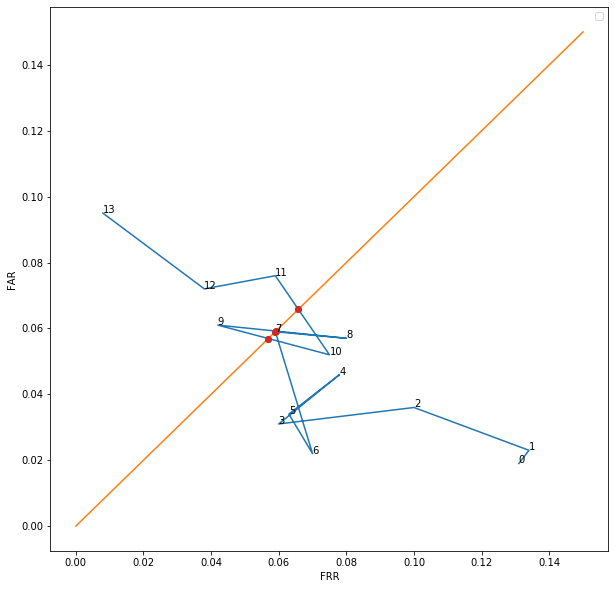

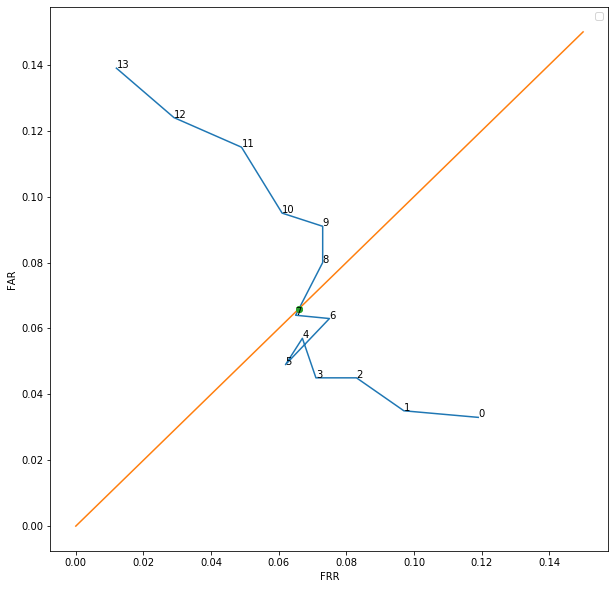

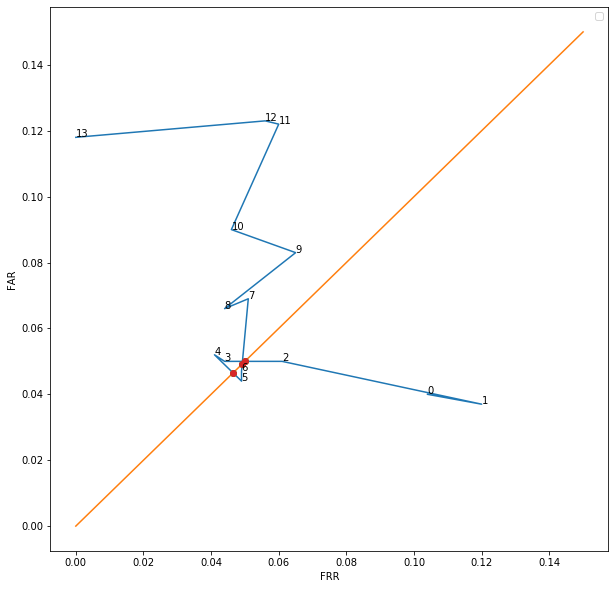

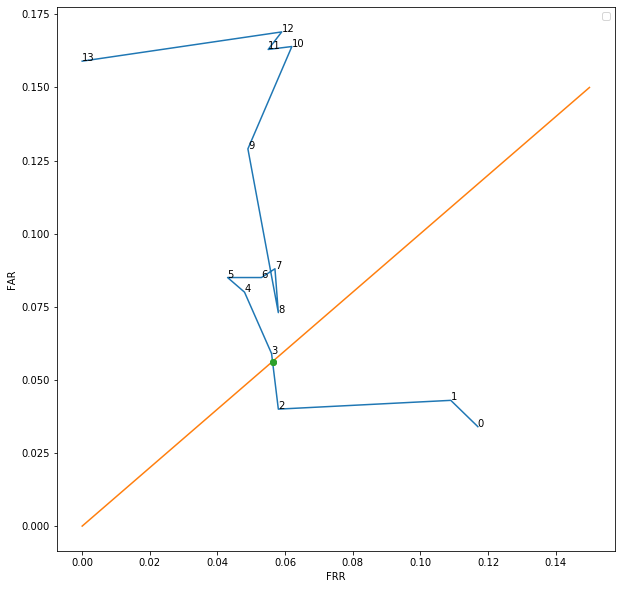

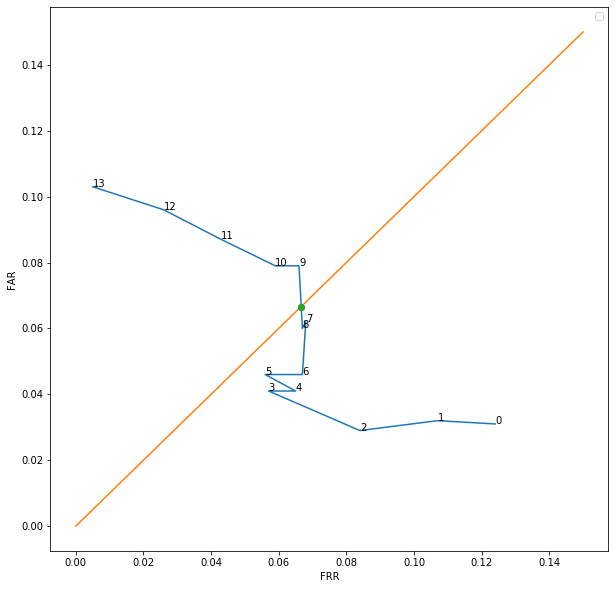

In [31]:
#1. train subject , train subject
counter_true_false_result(0,89,0,89) 

#2. train subject , new subject
counter_true_false_result(0,89, 90,108)

#3. new subject , new subject
counter_true_false_result(90,108, 0,89)

#4. new subject , new subject
counter_true_false_result(90,108, 90,108)

#5. all subject , all subject
counter_true_false_result(0,108, 0,108)

Creation of the directory /content/drive/My Drive/Orth_cosian/try1_2000_160os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift160 failed
1 )  0.235 . 
 86.1 % 
 true_result: 1722 false_result: 278 
 TP: 736 FN: 264 FRR: 0.264 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.139 

2 )  0.245 . 
 87.15 % 
 true_result: 1743 false_result: 257 
 TP: 764 FN: 236 FRR: 0.236 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.1285 

3 )  0.255 . 
 88.85 % 
 true_result: 1777 false_result: 223 
 TP: 802 FN: 198 FRR: 0.198 
 TN: 975 FP: 25 FAR: 0.025 
 EER: 0.1115 

4 )  0.265 . 
 90.6 % 
 true_result: 1812 false_result: 188 
 TP: 846 FN: 154 FRR: 0.154 
 TN: 966 FP: 34 FAR: 0.034 
 EER: 0.094 

5 )  0.275 . 
 92.0 % 
 true_result: 1840 false_result: 160 
 TP: 878 FN: 122 FRR: 0.122 
 TN: 962 FP: 38 FAR: 0.038 
 EER: 0.08 

6 )  0.285 . 
 93.35 % 
 true_result: 1867 false_result: 133 
 TP: 895 FN: 105 FRR: 0.105 
 TN: 972 FP: 28 FAR: 0.028 
 EER: 0.0665 

7 )  0.295 . 
 92.05 % 
 tr

No handles with labels found to put in legend.


19 )  0.415 . 
 92.4 % 
 true_result: 1848 false_result: 152 
 TP: 973 FN: 27 FRR: 0.027 
 TN: 875 FP: 125 FAR: 0.125 
 EER: 0.076 

POINT (0.06999999999999999 0.07000000000000001)
####sample img num:3_S1(0-89)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1_2000_160os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift160 failed
1 )  0.235 . 
 85.4 % 
 true_result: 1708 false_result: 292 
 TP: 735 FN: 265 FRR: 0.265 
 TN: 973 FP: 27 FAR: 0.027 
 EER: 0.14600000000000002 

2 )  0.245 . 
 86.4 % 
 true_result: 1728 false_result: 272 
 TP: 772 FN: 228 FRR: 0.228 
 TN: 956 FP: 44 FAR: 0.044 
 EER: 0.136 

3 )  0.255 . 
 89.1 % 
 true_result: 1782 false_result: 218 
 TP: 823 FN: 177 FRR: 0.177 
 TN: 959 FP: 41 FAR: 0.041 
 EER: 0.109 

4 )  0.265 . 
 90.75 % 
 true_result: 1815 false_result: 185 
 TP: 856 FN: 144 FRR: 0.144 
 TN: 959 FP: 41 FAR: 0.041 
 EER: 0.0925 

5 )  0.275 . 
 91.05 % 
 true_result: 1821 false_result: 179

No handles with labels found to put in legend.


19 )  0.415 . 
 88.8 % 
 true_result: 1776 false_result: 224 
 TP: 953 FN: 47 FRR: 0.047 
 TN: 823 FP: 177 FAR: 0.177 
 EER: 0.11199999999999999 

POINT (0.08165217391304348 0.08165217391304348)
####sample img num:3_S1(0-89)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1_2000_160os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift160 failed
1 )  0.235 . 
 85.95 % 
 true_result: 1719 false_result: 281 
 TP: 743 FN: 257 FRR: 0.257 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.1405 

2 )  0.245 . 
 90.6 % 
 true_result: 1812 false_result: 188 
 TP: 839 FN: 161 FRR: 0.161 
 TN: 973 FP: 27 FAR: 0.027 
 EER: 0.094 

3 )  0.255 . 
 91.45 % 
 true_result: 1829 false_result: 171 
 TP: 863 FN: 137 FRR: 0.137 
 TN: 966 FP: 34 FAR: 0.034 
 EER: 0.0855 

4 )  0.265 . 
 90.2 % 
 true_result: 1804 false_result: 196 
 TP: 845 FN: 155 FRR: 0.155 
 TN: 959 FP: 41 FAR: 0.041 
 EER: 0.098 

5 )  0.275 . 
 89.8 % 
 true_result: 1796 false_result: 

No handles with labels found to put in legend.


19 )  0.415 . 
 91.25 % 
 true_result: 1825 false_result: 175 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 825 FP: 175 FAR: 0.175 
 EER: 0.0875 

POINT (0.07950819672131147 0.07950819672131147)
####sample img num:3_S1(90-108)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1_2000_160os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift160 failed
1 )  0.235 . 
 84.15 % 
 true_result: 1683 false_result: 317 
 TP: 733 FN: 267 FRR: 0.267 
 TN: 950 FP: 50 FAR: 0.05 
 EER: 0.1585 

2 )  0.245 . 
 89.6 % 
 true_result: 1792 false_result: 208 
 TP: 834 FN: 166 FRR: 0.166 
 TN: 958 FP: 42 FAR: 0.042 
 EER: 0.10400000000000001 

3 )  0.255 . 
 89.25 % 
 true_result: 1785 false_result: 215 
 TP: 844 FN: 156 FRR: 0.156 
 TN: 941 FP: 59 FAR: 0.059 
 EER: 0.1075 

4 )  0.265 . 
 89.6 % 
 true_result: 1792 false_result: 208 
 TP: 853 FN: 147 FRR: 0.147 
 TN: 939 FP: 61 FAR: 0.061 
 EER: 0.104 

5 )  0.275 . 
 88.3 % 
 true_result: 1766 false_result: 2

No handles with labels found to put in legend.


19 )  0.415 . 
 89.5 % 
 true_result: 1790 false_result: 210 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 790 FP: 210 FAR: 0.21 
 EER: 0.105 

POINT (0.1092608695652174 0.1092608695652174)
####sample img num:3_S1(90-108)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1_2000_160os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift160 failed
1 )  0.235 . 
 86.7 % 
 true_result: 1734 false_result: 266 
 TP: 759 FN: 241 FRR: 0.241 
 TN: 975 FP: 25 FAR: 0.025 
 EER: 0.133 

2 )  0.245 . 
 88.25 % 
 true_result: 1765 false_result: 235 
 TP: 795 FN: 205 FRR: 0.205 
 TN: 970 FP: 30 FAR: 0.03 
 EER: 0.1175 

3 )  0.255 . 
 89.25 % 
 true_result: 1785 false_result: 215 
 TP: 810 FN: 190 FRR: 0.19 
 TN: 975 FP: 25 FAR: 0.025 
 EER: 0.1075 

4 )  0.265 . 
 91.95 % 
 true_result: 1839 false_result: 161 
 TP: 858 FN: 142 FRR: 0.142 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.08049999999999999 

5 )  0.275 . 
 90.25 % 
 true_result: 1805 false_result: 195

No handles with labels found to put in legend.


POINT (0.07016129032258064 0.07016129032258064)
####sample img num:3_S1(0-108)_S2(0-108)


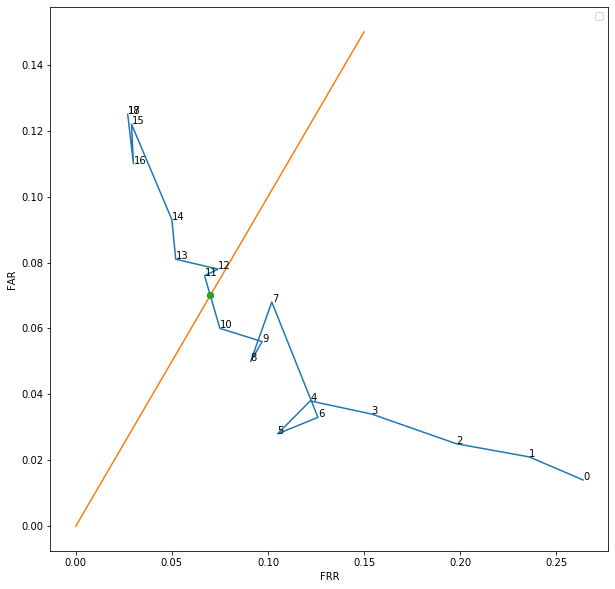

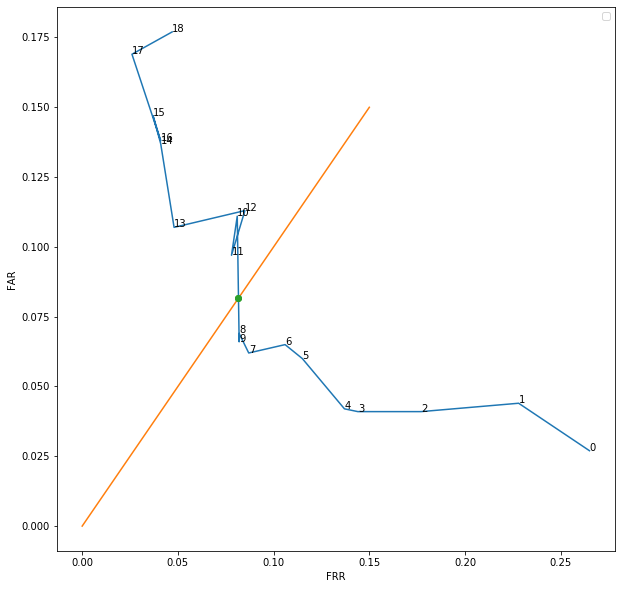

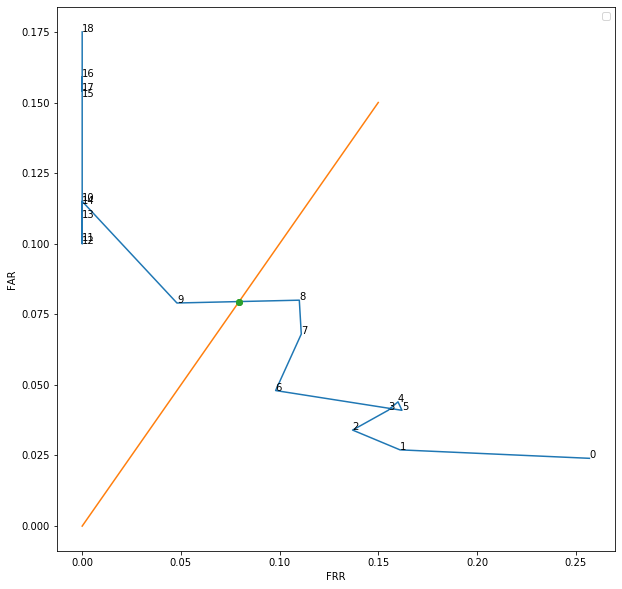

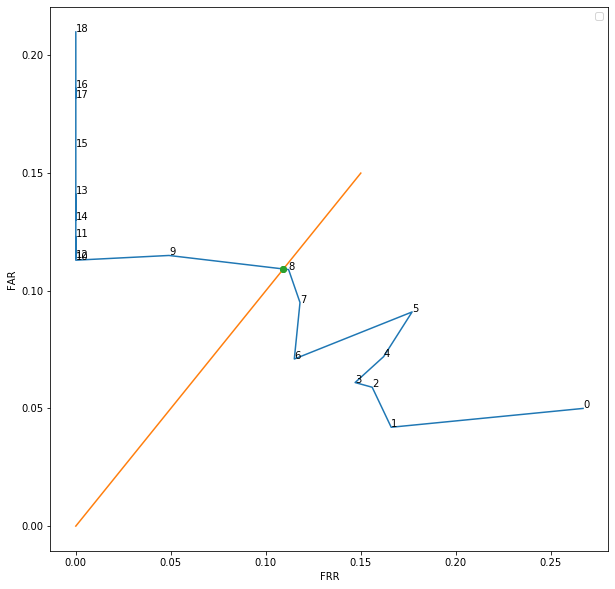

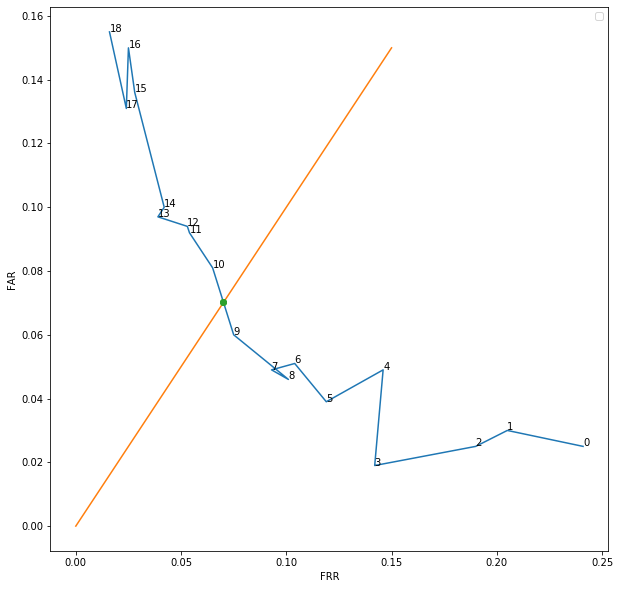

In [53]:
#1. train subject , train subject
counter_true_false_result(0,89,0,89) 

#2. train subject , new subject
counter_true_false_result(0,89, 90,108)

#3. new subject , new subject
counter_true_false_result(90,108, 0,89)

#4. new subject , new subject
counter_true_false_result(90,108, 90,108)

#5. all subject , all subject
counter_true_false_result(0,108, 0,108)

Successfully created the directory /content/drive/My Drive/Orth_cosian/try1_2000_8os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift8 
1 )  0.235 . 
 83.35 % 
 true_result: 1667 false_result: 333 
 TP: 686 FN: 314 FRR: 0.314 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.1665 

2 )  0.245 . 
 84.65 % 
 true_result: 1693 false_result: 307 
 TP: 720 FN: 280 FRR: 0.28 
 TN: 973 FP: 27 FAR: 0.027 
 EER: 0.15350000000000003 

3 )  0.255 . 
 85.8 % 
 true_result: 1716 false_result: 284 
 TP: 739 FN: 261 FRR: 0.261 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.14200000000000002 

4 )  0.265 . 
 86.0 % 
 true_result: 1720 false_result: 280 
 TP: 756 FN: 244 FRR: 0.244 
 TN: 964 FP: 36 FAR: 0.036 
 EER: 0.13999999999999999 

5 )  0.275 . 
 87.05 % 
 true_result: 1741 false_result: 259 
 TP: 784 FN: 216 FRR: 0.216 
 TN: 957 FP: 43 FAR: 0.043 
 EER: 0.1295 

6 )  0.285 . 
 86.65 % 
 true_result: 1733 false_result: 267 
 TP: 785 FN: 215 FRR: 0.215 
 TN: 948 FP: 52 FAR: 0.052 


No handles with labels found to put in legend.


19 )  0.415 . 
 89.75 % 
 true_result: 1795 false_result: 205 
 TP: 932 FN: 68 FRR: 0.068 
 TN: 863 FP: 137 FAR: 0.137 
 EER: 0.10250000000000001 

POINT (0.09642857142857141 0.09642857142857141)
####sample img num:3_S1(0-89)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1_2000_8os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 81.95 % 
 true_result: 1639 false_result: 361 
 TP: 679 FN: 321 FRR: 0.321 
 TN: 960 FP: 40 FAR: 0.04 
 EER: 0.1805 

2 )  0.245 . 
 84.7 % 
 true_result: 1694 false_result: 306 
 TP: 730 FN: 270 FRR: 0.27 
 TN: 964 FP: 36 FAR: 0.036 
 EER: 0.153 

3 )  0.255 . 
 85.2 % 
 true_result: 1704 false_result: 296 
 TP: 748 FN: 252 FRR: 0.252 
 TN: 956 FP: 44 FAR: 0.044 
 EER: 0.148 

4 )  0.265 . 
 85.2 % 
 true_result: 1704 false_result: 296 
 TP: 762 FN: 238 FRR: 0.238 
 TN: 942 FP: 58 FAR: 0.058 
 EER: 0.148 

5 )  0.275 . 
 85.75 % 
 true_result: 1715 false_result: 285 
 TP

No handles with labels found to put in legend.


19 )  0.415 . 
 86.7 % 
 true_result: 1734 false_result: 266 
 TP: 927 FN: 73 FRR: 0.073 
 TN: 807 FP: 193 FAR: 0.193 
 EER: 0.133 

POINT (0.1086190476190476 0.1086190476190476)
####sample img num:3_S1(0-89)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1_2000_8os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 66.9 % 
 true_result: 1338 false_result: 662 
 TP: 376 FN: 624 FRR: 0.624 
 TN: 962 FP: 38 FAR: 0.038 
 EER: 0.331 

2 )  0.245 . 
 65.95 % 
 true_result: 1319 false_result: 681 
 TP: 348 FN: 652 FRR: 0.652 
 TN: 971 FP: 29 FAR: 0.029 
 EER: 0.3405 

3 )  0.255 . 
 65.65 % 
 true_result: 1313 false_result: 687 
 TP: 351 FN: 649 FRR: 0.649 
 TN: 962 FP: 38 FAR: 0.038 
 EER: 0.3435 

4 )  0.265 . 
 64.7 % 
 true_result: 1294 false_result: 706 
 TP: 343 FN: 657 FRR: 0.657 
 TN: 951 FP: 49 FAR: 0.049 
 EER: 0.35300000000000004 

5 )  0.275 . 
 69.0 % 
 true_result: 1380 false_result: 620 
 

No handles with labels found to put in legend.


19 )  0.415 . 
 79.75 % 
 true_result: 1595 false_result: 405 
 TP: 785 FN: 215 FRR: 0.215 
 TN: 810 FP: 190 FAR: 0.19 
 EER: 0.2025 

LINESTRING EMPTY
####sample img num:3_S1(90-108)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1_2000_8os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 66.75 % 
 true_result: 1335 false_result: 665 
 TP: 370 FN: 630 FRR: 0.63 
 TN: 965 FP: 35 FAR: 0.035 
 EER: 0.3325 

2 )  0.245 . 
 64.65 % 
 true_result: 1293 false_result: 707 
 TP: 337 FN: 663 FRR: 0.663 
 TN: 956 FP: 44 FAR: 0.044 
 EER: 0.35350000000000004 

3 )  0.255 . 
 64.15 % 
 true_result: 1283 false_result: 717 
 TP: 336 FN: 664 FRR: 0.664 
 TN: 947 FP: 53 FAR: 0.053 
 EER: 0.35850000000000004 

4 )  0.265 . 
 66.05 % 
 true_result: 1321 false_result: 679 
 TP: 389 FN: 611 FRR: 0.611 
 TN: 932 FP: 68 FAR: 0.068 
 EER: 0.3395 

5 )  0.275 . 
 67.05 % 
 true_result: 1341 false_result: 659 
 TP: 425 FN:

No handles with labels found to put in legend.


19 )  0.415 . 
 77.9 % 
 true_result: 1558 false_result: 442 
 TP: 794 FN: 206 FRR: 0.206 
 TN: 764 FP: 236 FAR: 0.236 
 EER: 0.22099999999999997 

LINESTRING EMPTY
####sample img num:3_S1(90-108)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try1_2000_8os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 81.1 % 
 true_result: 1622 false_result: 378 
 TP: 636 FN: 364 FRR: 0.364 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.189 

2 )  0.245 . 
 80.05 % 
 true_result: 1601 false_result: 399 
 TP: 641 FN: 359 FRR: 0.359 
 TN: 960 FP: 40 FAR: 0.04 
 EER: 0.19949999999999998 

3 )  0.255 . 
 81.6 % 
 true_result: 1632 false_result: 368 
 TP: 654 FN: 346 FRR: 0.346 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.184 

4 )  0.265 . 
 82.1 % 
 true_result: 1642 false_result: 358 
 TP: 682 FN: 318 FRR: 0.318 
 TN: 960 FP: 40 FAR: 0.04 
 EER: 0.179 

5 )  0.275 . 
 84.6 % 
 true_result: 1692 false_result: 308 
 TP: 731 FN: 269 F

No handles with labels found to put in legend.


19 )  0.415 . 
 86.95 % 
 true_result: 1739 false_result: 261 
 TP: 906 FN: 94 FRR: 0.094 
 TN: 833 FP: 167 FAR: 0.167 
 EER: 0.1305 

POINT (0.1335384615384616 0.1335384615384616)
####sample img num:3_S1(0-108)_S2(0-108)


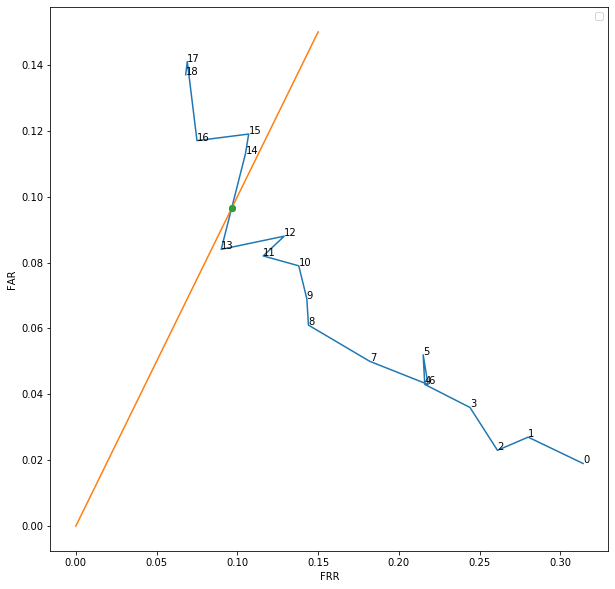

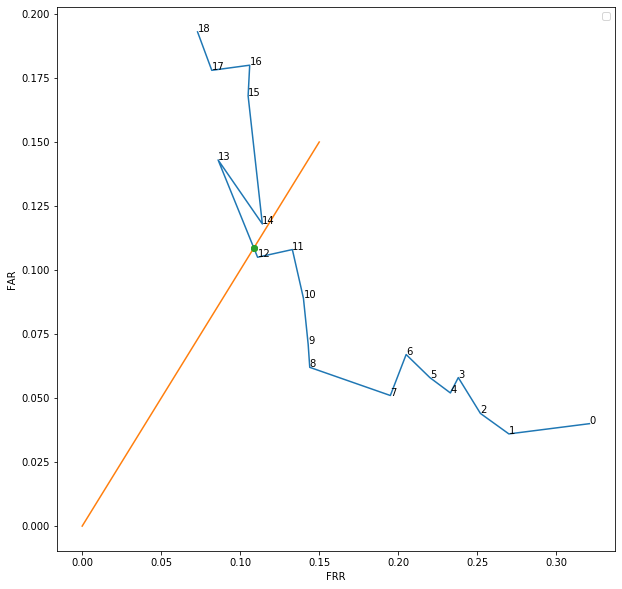

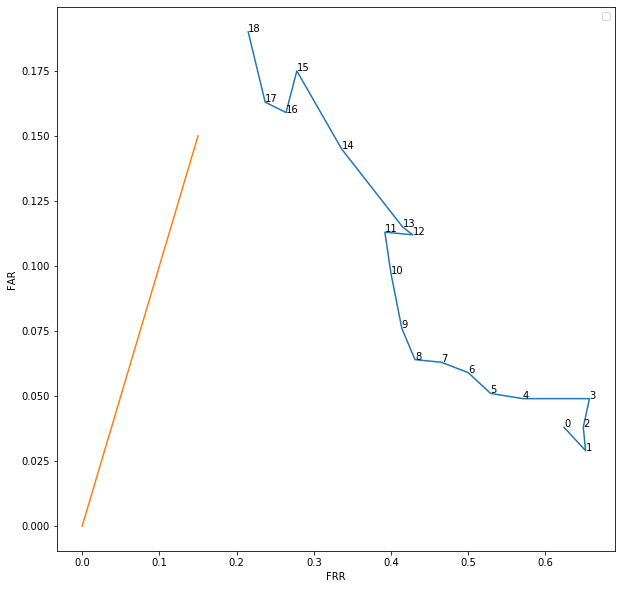

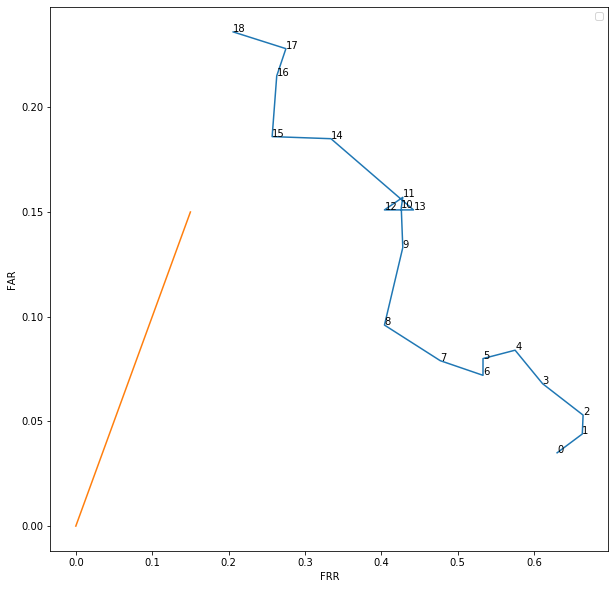

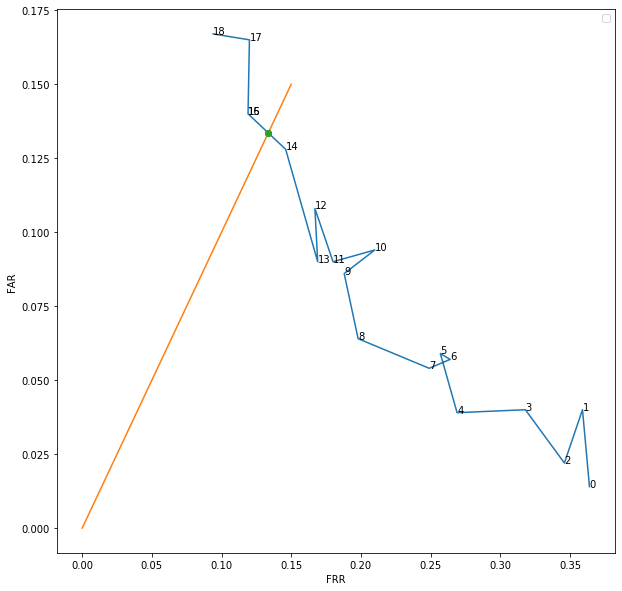

In [69]:
#1. train subject , train subject
counter_true_false_result(0,89,0,89) 

#2. train subject , new subject
counter_true_false_result(0,89, 90,108)

#3. new subject , new subject
counter_true_false_result(90,108, 0,89)

#4. new subject , new subject
counter_true_false_result(90,108, 90,108)

#5. all subject , all subject
counter_true_false_result(0,108, 0,108)

Creation of the directory /content/drive/My Drive/Orth_cosian/try2_2000_8os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 83.95 % 
 true_result: 1679 false_result: 321 
 TP: 699 FN: 301 FRR: 0.301 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.1605 

2 )  0.245 . 
 85.0 % 
 true_result: 1700 false_result: 300 
 TP: 734 FN: 266 FRR: 0.266 
 TN: 966 FP: 34 FAR: 0.034 
 EER: 0.15000000000000002 

3 )  0.255 . 
 86.25 % 
 true_result: 1725 false_result: 275 
 TP: 745 FN: 255 FRR: 0.255 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.1375 

4 )  0.265 . 
 88.35 % 
 true_result: 1767 false_result: 233 
 TP: 802 FN: 198 FRR: 0.198 
 TN: 965 FP: 35 FAR: 0.035 
 EER: 0.1165 

5 )  0.275 . 
 88.6 % 
 true_result: 1772 false_result: 228 
 TP: 822 FN: 178 FRR: 0.178 
 TN: 950 FP: 50 FAR: 0.05 
 EER: 0.11399999999999999 

6 )  0.285 . 
 88.6 % 
 true_result: 1772 false_result: 228 
 TP: 817 FN: 183 FRR: 0.183 
 TN: 955 FP: 45 FAR: 0.045 
 EER: 0.11399999999

No handles with labels found to put in legend.


19 )  0.415 . 
 89.0 % 
 true_result: 1780 false_result: 220 
 TP: 928 FN: 72 FRR: 0.072 
 TN: 852 FP: 148 FAR: 0.148 
 EER: 0.10999999999999999 

POINT (0.08504651162790698 0.08504651162790697)
####sample img num:3_S1(0-89)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try2_2000_8os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 82.7 % 
 true_result: 1654 false_result: 346 
 TP: 682 FN: 318 FRR: 0.318 
 TN: 972 FP: 28 FAR: 0.028 
 EER: 0.17300000000000001 

2 )  0.245 . 
 83.4 % 
 true_result: 1668 false_result: 332 
 TP: 705 FN: 295 FRR: 0.295 
 TN: 963 FP: 37 FAR: 0.037 
 EER: 0.16599999999999998 

3 )  0.255 . 
 84.45 % 
 true_result: 1689 false_result: 311 
 TP: 728 FN: 272 FRR: 0.272 
 TN: 961 FP: 39 FAR: 0.039 
 EER: 0.1555 

4 )  0.265 . 
 87.6 % 
 true_result: 1752 false_result: 248 
 TP: 809 FN: 191 FRR: 0.191 
 TN: 943 FP: 57 FAR: 0.057 
 EER: 0.124 

5 )  0.275 . 
 88.5 % 
 true_result:

No handles with labels found to put in legend.


19 )  0.415 . 
 88.5 % 
 true_result: 1770 false_result: 230 
 TP: 933 FN: 67 FRR: 0.067 
 TN: 837 FP: 163 FAR: 0.163 
 EER: 0.115 

POINT (0.1037777777777778 0.1037777777777778)
####sample img num:3_S1(0-89)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try2_2000_8os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 74.25 % 
 true_result: 1485 false_result: 515 
 TP: 517 FN: 483 FRR: 0.483 
 TN: 968 FP: 32 FAR: 0.032 
 EER: 0.2575 

2 )  0.245 . 
 74.75 % 
 true_result: 1495 false_result: 505 
 TP: 519 FN: 481 FRR: 0.481 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.2525 

3 )  0.255 . 
 74.2 % 
 true_result: 1484 false_result: 516 
 TP: 519 FN: 481 FRR: 0.481 
 TN: 965 FP: 35 FAR: 0.035 
 EER: 0.258 

4 )  0.265 . 
 77.65 % 
 true_result: 1553 false_result: 447 
 TP: 611 FN: 389 FRR: 0.389 
 TN: 942 FP: 58 FAR: 0.058 
 EER: 0.2235 

5 )  0.275 . 
 77.5 % 
 true_result: 1550 false_result: 450 
 TP: 604 FN: 

No handles with labels found to put in legend.


19 )  0.415 . 
 84.5 % 
 true_result: 1690 false_result: 310 
 TP: 886 FN: 114 FRR: 0.114 
 TN: 804 FP: 196 FAR: 0.196 
 EER: 0.155 

POINT (0.1496666666666667 0.1496666666666667)
####sample img num:3_S1(90-108)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try2_2000_8os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 73.95 % 
 true_result: 1479 false_result: 521 
 TP: 519 FN: 481 FRR: 0.481 
 TN: 960 FP: 40 FAR: 0.04 
 EER: 0.2605 

2 )  0.245 . 
 74.05 % 
 true_result: 1481 false_result: 519 
 TP: 523 FN: 477 FRR: 0.477 
 TN: 958 FP: 42 FAR: 0.042 
 EER: 0.2595 

3 )  0.255 . 
 73.75 % 
 true_result: 1475 false_result: 525 
 TP: 509 FN: 491 FRR: 0.491 
 TN: 966 FP: 34 FAR: 0.034 
 EER: 0.2625 

4 )  0.265 . 
 79.75 % 
 true_result: 1595 false_result: 405 
 TP: 642 FN: 358 FRR: 0.358 
 TN: 953 FP: 47 FAR: 0.047 
 EER: 0.20249999999999999 

5 )  0.275 . 
 77.65 % 
 true_result: 1553 false_result: 44

No handles with labels found to put in legend.


19 )  0.415 . 
 82.6 % 
 true_result: 1652 false_result: 348 
 TP: 899 FN: 101 FRR: 0.101 
 TN: 753 FP: 247 FAR: 0.247 
 EER: 0.174 

POINT (0.1617857142857143 0.1617857142857143)
####sample img num:3_S1(90-108)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try2_2000_8os_480spw best point model- cosian dist_true ORTH new model3sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 80.85 % 
 true_result: 1617 false_result: 383 
 TP: 639 FN: 361 FRR: 0.361 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.1915 

2 )  0.245 . 
 83.1 % 
 true_result: 1662 false_result: 338 
 TP: 690 FN: 310 FRR: 0.31 
 TN: 972 FP: 28 FAR: 0.028 
 EER: 0.169 

3 )  0.255 . 
 83.0 % 
 true_result: 1660 false_result: 340 
 TP: 683 FN: 317 FRR: 0.317 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.17 

4 )  0.265 . 
 85.05 % 
 true_result: 1701 false_result: 299 
 TP: 743 FN: 257 FRR: 0.257 
 TN: 958 FP: 42 FAR: 0.042 
 EER: 0.1495 

5 )  0.275 . 
 87.4 % 
 true_result: 1748 false_result: 252 
 TP: 792 FN: 2

No handles with labels found to put in legend.


19 )  0.415 . 
 87.6 % 
 true_result: 1752 false_result: 248 
 TP: 926 FN: 74 FRR: 0.074 
 TN: 826 FP: 174 FAR: 0.174 
 EER: 0.124 

POINT (0.1133333333333333 0.1133333333333333)
####sample img num:3_S1(0-108)_S2(0-108)


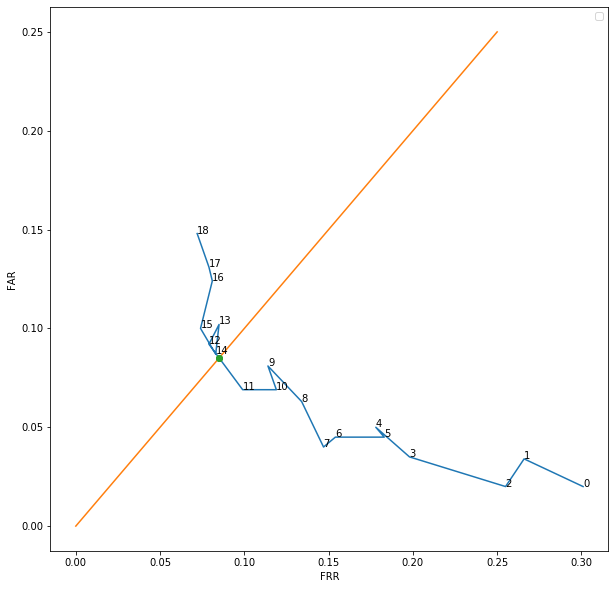

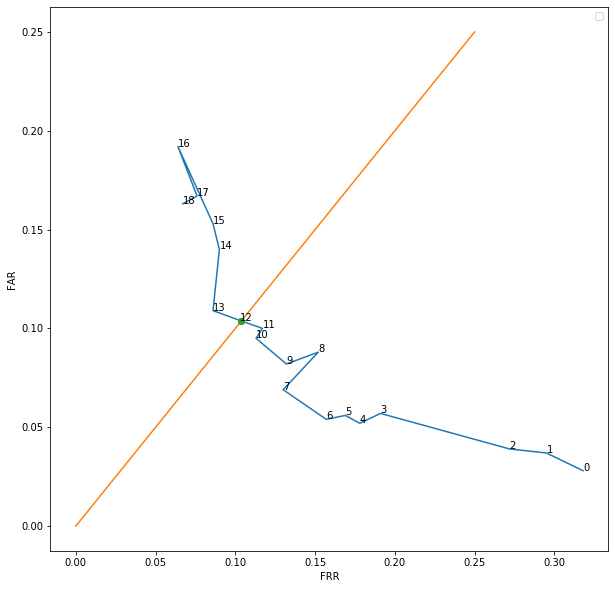

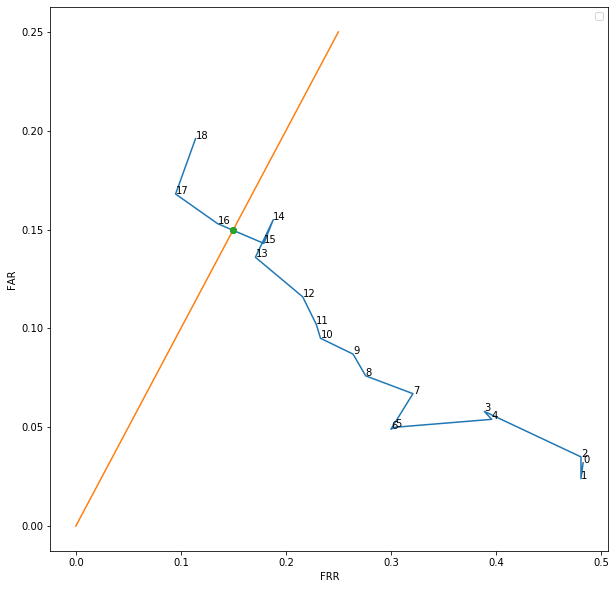

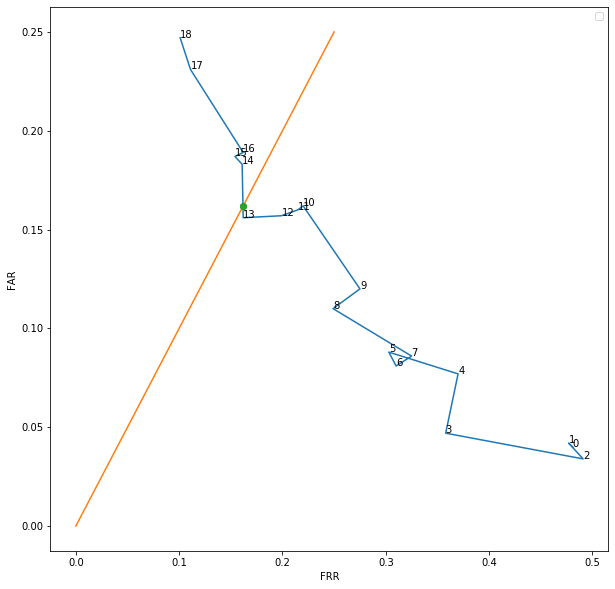

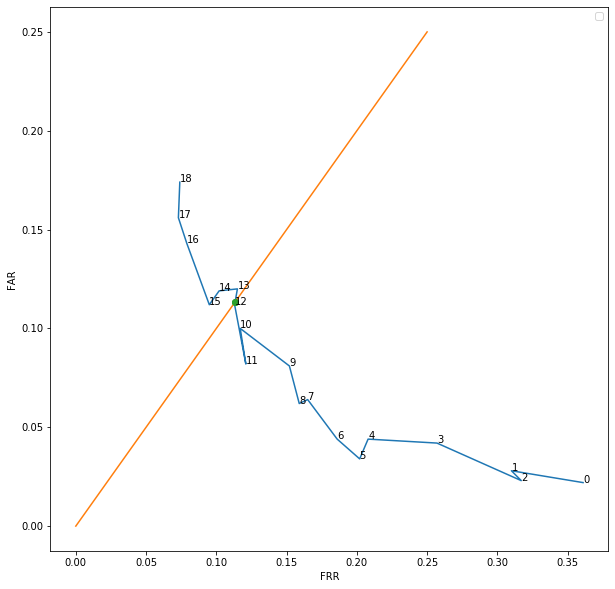

In [81]:
#1. train subject , train subject
counter_true_false_result(0,89,0,89) 

#2. train subject , new subject
counter_true_false_result(0,89, 90,108)

#3. new subject , new subject
counter_true_false_result(90,108, 0,89)

#4. new subject , new subject
counter_true_false_result(90,108, 90,108)

#5. all subject , all subject
counter_true_false_result(0,108, 0,108)

Creation of the directory /content/drive/My Drive/Orth_cosian/try2_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 83.85 % 
 true_result: 1677 false_result: 323 
 TP: 701 FN: 299 FRR: 0.299 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.1615 

2 )  0.245 . 
 84.8 % 
 true_result: 1696 false_result: 304 
 TP: 715 FN: 285 FRR: 0.285 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.152 

3 )  0.255 . 
 86.55 % 
 true_result: 1731 false_result: 269 
 TP: 746 FN: 254 FRR: 0.254 
 TN: 985 FP: 15 FAR: 0.015 
 EER: 0.1345 

4 )  0.265 . 
 86.75 % 
 true_result: 1735 false_result: 265 
 TP: 761 FN: 239 FRR: 0.239 
 TN: 974 FP: 26 FAR: 0.026 
 EER: 0.1325 

5 )  0.275 . 
 87.15 % 
 true_result: 1743 false_result: 257 
 TP: 782 FN: 218 FRR: 0.218 
 TN: 961 FP: 39 FAR: 0.039 
 EER: 0.1285 

6 )  0.285 . 
 87.75 % 
 true_result: 1755 false_result: 245 
 TP: 793 FN: 207 FRR: 0.207 
 TN: 962 FP: 38 FAR: 0.038 
 EER: 0.1225 

7 )  0.295 . 
 87.65 % 


No handles with labels found to put in legend.


24 )  0.465 . 
 87.45 % 
 true_result: 1749 false_result: 251 
 TP: 977 FN: 23 FRR: 0.023 
 TN: 772 FP: 228 FAR: 0.228 
 EER: 0.1255 

POINT (0.0871578947368421 0.0871578947368421)
####sample img num:1_S1(0-89)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try2_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 83.2 % 
 true_result: 1664 false_result: 336 
 TP: 695 FN: 305 FRR: 0.305 
 TN: 969 FP: 31 FAR: 0.031 
 EER: 0.16799999999999998 

2 )  0.245 . 
 84.25 % 
 true_result: 1685 false_result: 315 
 TP: 727 FN: 273 FRR: 0.273 
 TN: 958 FP: 42 FAR: 0.042 
 EER: 0.1575 

3 )  0.255 . 
 85.4 % 
 true_result: 1708 false_result: 292 
 TP: 744 FN: 256 FRR: 0.256 
 TN: 964 FP: 36 FAR: 0.036 
 EER: 0.146 

4 )  0.265 . 
 85.7 % 
 true_result: 1714 false_result: 286 
 TP: 771 FN: 229 FRR: 0.229 
 TN: 943 FP: 57 FAR: 0.057 
 EER: 0.14300000000000002 

5 )  0.275 . 
 87.1 % 
 true_result: 1742 false_

No handles with labels found to put in legend.


24 )  0.465 . 
 84.55 % 
 true_result: 1691 false_result: 309 
 TP: 965 FN: 35 FRR: 0.035 
 TN: 726 FP: 274 FAR: 0.274 
 EER: 0.15450000000000003 

POINT (0.1102631578947368 0.1102631578947368)
####sample img num:1_S1(0-89)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try2_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 76.3 % 
 true_result: 1526 false_result: 474 
 TP: 555 FN: 445 FRR: 0.445 
 TN: 971 FP: 29 FAR: 0.029 
 EER: 0.23700000000000002 

2 )  0.245 . 
 78.7 % 
 true_result: 1574 false_result: 426 
 TP: 613 FN: 387 FRR: 0.387 
 TN: 961 FP: 39 FAR: 0.039 
 EER: 0.213 

3 )  0.255 . 
 81.65 % 
 true_result: 1633 false_result: 367 
 TP: 688 FN: 312 FRR: 0.312 
 TN: 945 FP: 55 FAR: 0.055 
 EER: 0.1835 

4 )  0.265 . 
 81.6 % 
 true_result: 1632 false_result: 368 
 TP: 677 FN: 323 FRR: 0.323 
 TN: 955 FP: 45 FAR: 0.045 
 EER: 0.184 

5 )  0.275 . 
 81.4 % 
 true_result: 1628 false

No handles with labels found to put in legend.


24 )  0.465 . 
 86.9 % 
 true_result: 1738 false_result: 262 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 738 FP: 262 FAR: 0.262 
 EER: 0.131 

POINT (0.09887499999999999 0.098875)
####sample img num:1_S1(90-108)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try2_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 77.6 % 
 true_result: 1552 false_result: 448 
 TP: 592 FN: 408 FRR: 0.408 
 TN: 960 FP: 40 FAR: 0.04 
 EER: 0.22399999999999998 

2 )  0.245 . 
 79.25 % 
 true_result: 1585 false_result: 415 
 TP: 644 FN: 356 FRR: 0.356 
 TN: 941 FP: 59 FAR: 0.059 
 EER: 0.2075 

3 )  0.255 . 
 81.0 % 
 true_result: 1620 false_result: 380 
 TP: 671 FN: 329 FRR: 0.329 
 TN: 949 FP: 51 FAR: 0.051 
 EER: 0.19 

4 )  0.265 . 
 80.75 % 
 true_result: 1615 false_result: 385 
 TP: 657 FN: 343 FRR: 0.343 
 TN: 958 FP: 42 FAR: 0.042 
 EER: 0.1925 

5 )  0.275 . 
 80.7 % 
 true_result: 1614 false_result: 386 
 TP: 677 FN:

No handles with labels found to put in legend.


24 )  0.465 . 
 85.35 % 
 true_result: 1707 false_result: 293 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 707 FP: 293 FAR: 0.293 
 EER: 0.1465 

POINT (0.1220212765957447 0.1220212765957447)
####sample img num:1_S1(90-108)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try2_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 83.35 % 
 true_result: 1667 false_result: 333 
 TP: 695 FN: 305 FRR: 0.305 
 TN: 972 FP: 28 FAR: 0.028 
 EER: 0.1665 

2 )  0.245 . 
 83.85 % 
 true_result: 1677 false_result: 323 
 TP: 709 FN: 291 FRR: 0.291 
 TN: 968 FP: 32 FAR: 0.032 
 EER: 0.16149999999999998 

3 )  0.255 . 
 85.0 % 
 true_result: 1700 false_result: 300 
 TP: 737 FN: 263 FRR: 0.263 
 TN: 963 FP: 37 FAR: 0.037 
 EER: 0.15 

4 )  0.265 . 
 86.05 % 
 true_result: 1721 false_result: 279 
 TP: 760 FN: 240 FRR: 0.24 
 TN: 961 FP: 39 FAR: 0.039 
 EER: 0.13949999999999999 

5 )  0.275 . 
 85.35 % 
 true_result: 1707 fal

No handles with labels found to put in legend.


24 )  0.465 . 
 87.65 % 
 true_result: 1753 false_result: 247 
 TP: 978 FN: 22 FRR: 0.022 
 TN: 775 FP: 225 FAR: 0.225 
 EER: 0.1235 

POINT (0.09465116279069768 0.09465116279069767)
####sample img num:1_S1(0-108)_S2(0-108)


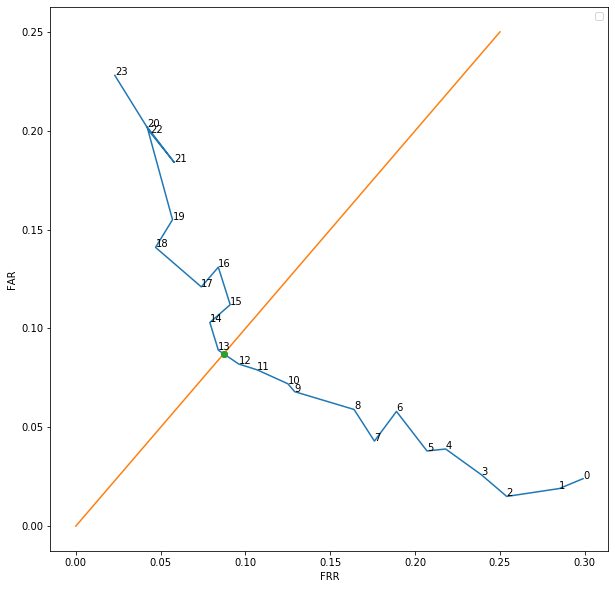

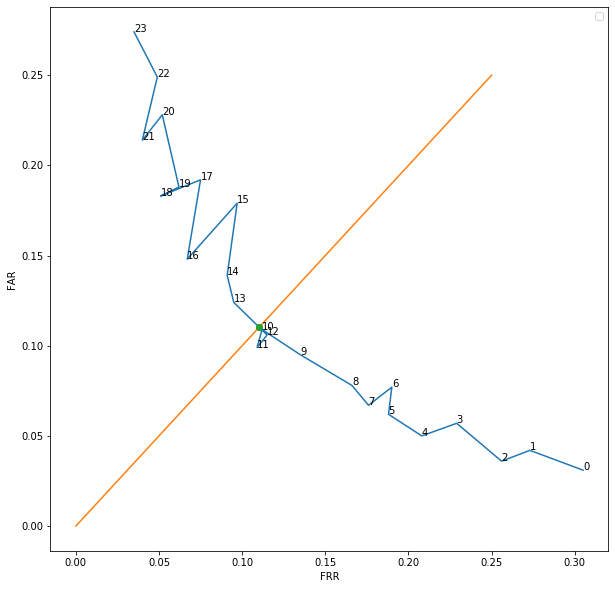

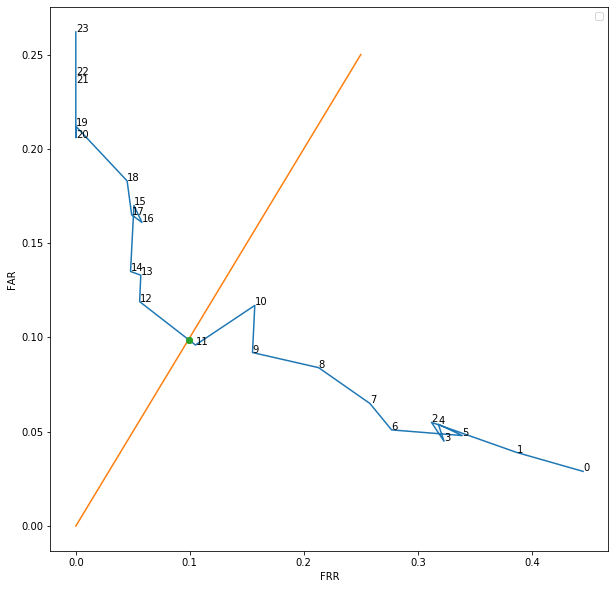

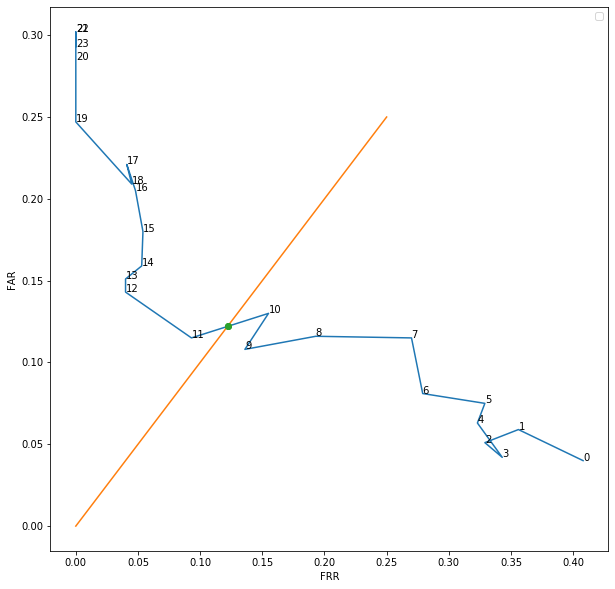

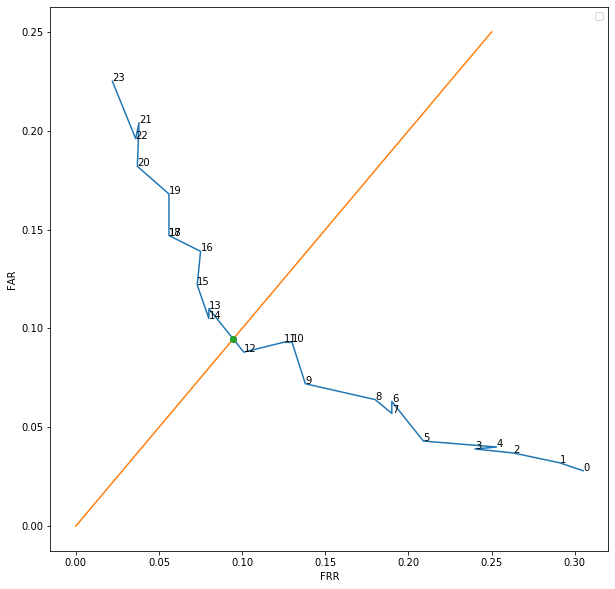

In [88]:
#1. train subject , train subject
counter_true_false_result(0,89,0,89) 

#2. train subject , new subject
counter_true_false_result(0,89, 90,108)

#3. new subject , new subject
counter_true_false_result(90,108, 0,89)

#4. new subject , new subject
counter_true_false_result(90,108, 90,108)

#5. all subject , all subject
counter_true_false_result(0,108, 0,108)

Creation of the directory /content/drive/My Drive/Orth_cosian/try3_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 91.85 % 
 true_result: 1837 false_result: 163 
 TP: 859 FN: 141 FRR: 0.141 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.08149999999999999 

2 )  0.245 . 
 92.8 % 
 true_result: 1856 false_result: 144 
 TP: 882 FN: 118 FRR: 0.118 
 TN: 974 FP: 26 FAR: 0.026 
 EER: 0.072 

3 )  0.255 . 
 94.85 % 
 true_result: 1897 false_result: 103 
 TP: 917 FN: 83 FRR: 0.083 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.051500000000000004 

4 )  0.265 . 
 94.85 % 
 true_result: 1897 false_result: 103 
 TP: 925 FN: 75 FRR: 0.075 
 TN: 972 FP: 28 FAR: 0.028 
 EER: 0.0515 

5 )  0.275 . 
 94.85 % 
 true_result: 1897 false_result: 103 
 TP: 929 FN: 71 FRR: 0.071 
 TN: 968 FP: 32 FAR: 0.032 
 EER: 0.0515 

6 )  0.285 . 
 94.35 % 
 true_result: 1887 false_result: 113 
 TP: 932 FN: 68 FRR: 0.068 
 TN: 955 FP: 45 FAR: 0.045 
 EER: 0.0565 

7 

No handles with labels found to put in legend.


24 )  0.465 . 
 90.55 % 
 true_result: 1811 false_result: 189 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 811 FP: 189 FAR: 0.189 
 EER: 0.0945 

MULTIPOINT (0.0554 0.0554, 0.05555555555555555 0.05555555555555556, 0.07236363636363635 0.07236363636363635)
####sample img num:1_S1(0-89)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try3_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 91.75 % 
 true_result: 1835 false_result: 165 
 TP: 865 FN: 135 FRR: 0.135 
 TN: 970 FP: 30 FAR: 0.03 
 EER: 0.0825 

2 )  0.245 . 
 93.4 % 
 true_result: 1868 false_result: 132 
 TP: 903 FN: 97 FRR: 0.097 
 TN: 965 FP: 35 FAR: 0.035 
 EER: 0.066 

3 )  0.255 . 
 92.8 % 
 true_result: 1856 false_result: 144 
 TP: 904 FN: 96 FRR: 0.096 
 TN: 952 FP: 48 FAR: 0.048 
 EER: 0.07200000000000001 

4 )  0.265 . 
 94.6 % 
 true_result: 1892 false_result: 108 
 TP: 937 FN: 63 FRR: 0.063 
 TN: 955 FP: 45 FAR: 0.045 
 EER: 0.054 

5 )  

No handles with labels found to put in legend.


24 )  0.465 . 
 87.15 % 
 true_result: 1743 false_result: 257 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 743 FP: 257 FAR: 0.257 
 EER: 0.1285 

POINT (0.0636 0.0636)
####sample img num:1_S1(0-89)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try3_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 92.1 % 
 true_result: 1842 false_result: 158 
 TP: 878 FN: 122 FRR: 0.122 
 TN: 964 FP: 36 FAR: 0.036 
 EER: 0.079 

2 )  0.245 . 
 91.85 % 
 true_result: 1837 false_result: 163 
 TP: 885 FN: 115 FRR: 0.115 
 TN: 952 FP: 48 FAR: 0.048 
 EER: 0.0815 

3 )  0.255 . 
 95.05 % 
 true_result: 1901 false_result: 99 
 TP: 940 FN: 60 FRR: 0.06 
 TN: 961 FP: 39 FAR: 0.039 
 EER: 0.0495 

4 )  0.265 . 
 95.35 % 
 true_result: 1907 false_result: 93 
 TP: 943 FN: 57 FRR: 0.057 
 TN: 964 FP: 36 FAR: 0.036 
 EER: 0.0465 

5 )  0.275 . 
 94.8 % 
 true_result: 1896 false_result: 104 
 TP: 939 FN: 61 FRR: 0.061 
 TN: 957 FP:

No handles with labels found to put in legend.


24 )  0.465 . 
 86.6 % 
 true_result: 1732 false_result: 268 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 732 FP: 268 FAR: 0.268 
 EER: 0.134 

POINT (0.06175 0.06175)
####sample img num:1_S1(90-108)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try3_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 92.9 % 
 true_result: 1858 false_result: 142 
 TP: 904 FN: 96 FRR: 0.096 
 TN: 954 FP: 46 FAR: 0.046 
 EER: 0.07100000000000001 

2 )  0.245 . 
 91.65 % 
 true_result: 1833 false_result: 167 
 TP: 885 FN: 115 FRR: 0.115 
 TN: 948 FP: 52 FAR: 0.052 
 EER: 0.0835 

3 )  0.255 . 
 94.6 % 
 true_result: 1892 false_result: 108 
 TP: 941 FN: 59 FRR: 0.059 
 TN: 951 FP: 49 FAR: 0.049 
 EER: 0.054 

4 )  0.265 . 
 94.9 % 
 true_result: 1898 false_result: 102 
 TP: 946 FN: 54 FRR: 0.054 
 TN: 952 FP: 48 FAR: 0.048 
 EER: 0.051000000000000004 

5 )  0.275 . 
 94.45 % 
 true_result: 1889 false_result: 111 
 TP: 945 FN:

No handles with labels found to put in legend.


24 )  0.465 . 
 85.7 % 
 true_result: 1714 false_result: 286 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 714 FP: 286 FAR: 0.286 
 EER: 0.143 

POINT (0.05485714285714285 0.05485714285714285)
####sample img num:1_S1(90-108)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try3_2000_160os_480spw best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 92.6 % 
 true_result: 1852 false_result: 148 
 TP: 876 FN: 124 FRR: 0.124 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.074 

2 )  0.245 . 
 93.0 % 
 true_result: 1860 false_result: 140 
 TP: 895 FN: 105 FRR: 0.105 
 TN: 965 FP: 35 FAR: 0.035 
 EER: 0.07 

3 )  0.255 . 
 94.65 % 
 true_result: 1893 false_result: 107 
 TP: 916 FN: 84 FRR: 0.084 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.053500000000000006 

4 )  0.265 . 
 94.8 % 
 true_result: 1896 false_result: 104 
 TP: 939 FN: 61 FRR: 0.061 
 TN: 957 FP: 43 FAR: 0.043 
 EER: 0.052 

5 )  0.275 . 
 94.65 % 
 true_result: 1893 false_result: 107 
 

No handles with labels found to put in legend.


24 )  0.465 . 
 87.75 % 
 true_result: 1755 false_result: 245 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 755 FP: 245 FAR: 0.245 
 EER: 0.1225 

POINT (0.06802564102564103 0.06802564102564103)
####sample img num:1_S1(0-108)_S2(0-108)


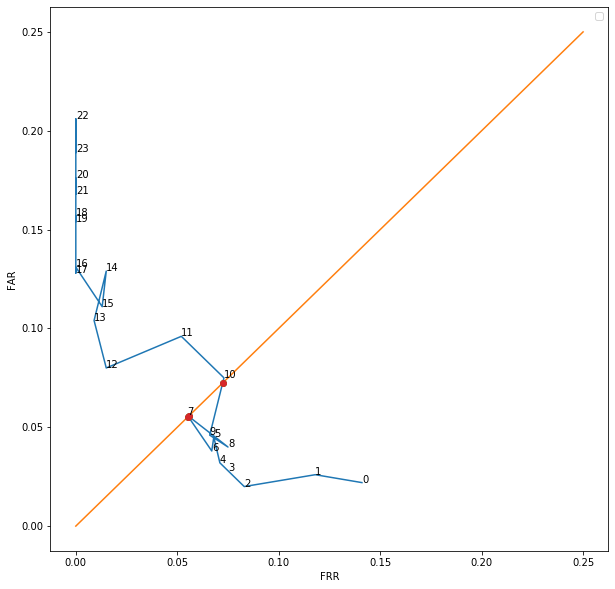

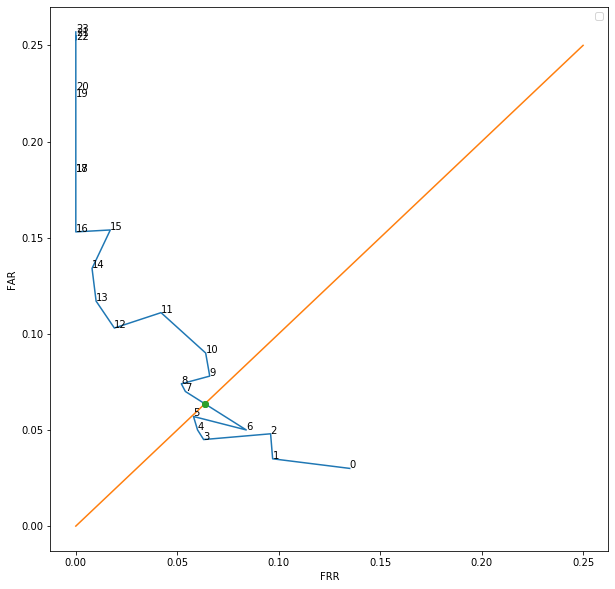

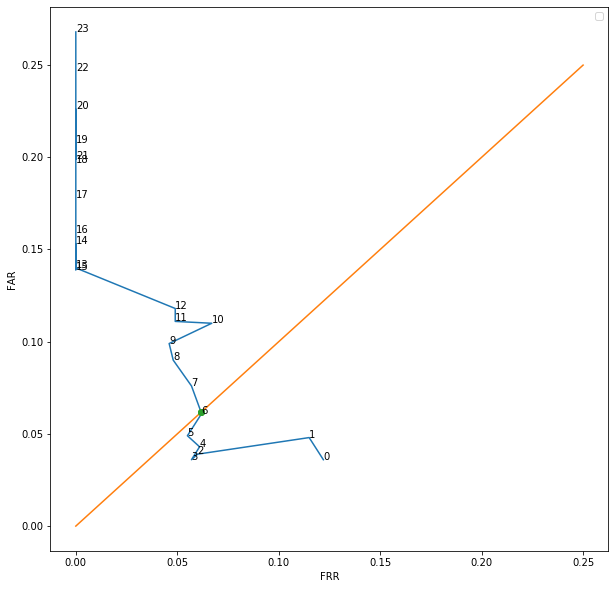

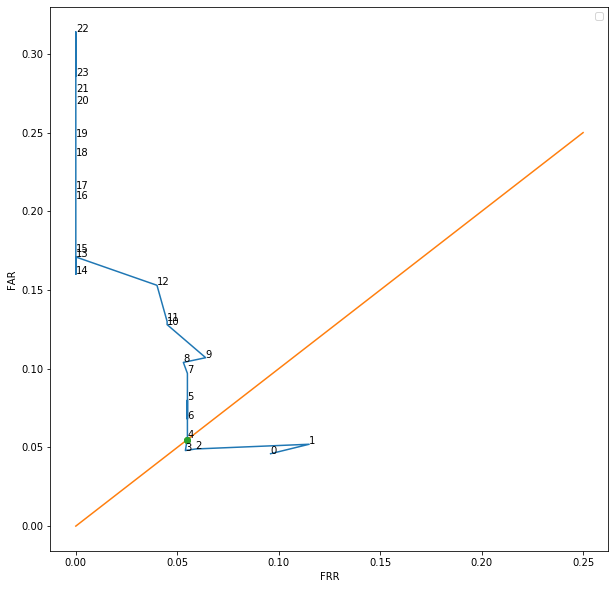

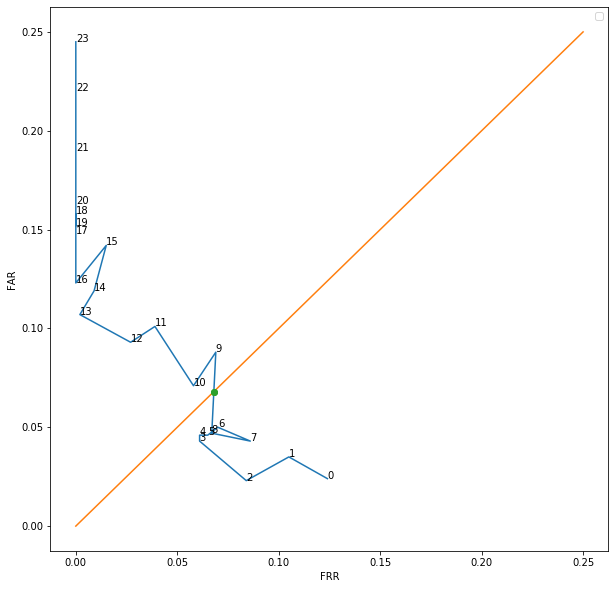

In [92]:
#1. train subject , train subject
counter_true_false_result(0,89,0,89) 

#2. train subject , new subject
counter_true_false_result(0,89, 90,108)

#3. new subject , new subject
counter_true_false_result(90,108, 0,89)

#4. new subject , new subject
counter_true_false_result(90,108, 90,108)

#5. all subject , all subject
counter_true_false_result(0,108, 0,108)

Creation of the directory /content/drive/My Drive/Orth_cosian/try4_2000_160os_480spw_far best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 84.8 % 
 true_result: 1696 false_result: 304 
 TP: 716 FN: 284 FRR: 0.284 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.152 

2 )  0.245 . 
 87.85 % 
 true_result: 1757 false_result: 243 
 TP: 779 FN: 221 FRR: 0.221 
 TN: 978 FP: 22 FAR: 0.022 
 EER: 0.1215 

3 )  0.255 . 
 89.55 % 
 true_result: 1791 false_result: 209 
 TP: 808 FN: 192 FRR: 0.192 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.10450000000000001 

4 )  0.265 . 
 88.6 % 
 true_result: 1772 false_result: 228 
 TP: 801 FN: 199 FRR: 0.199 
 TN: 971 FP: 29 FAR: 0.029 
 EER: 0.114 

5 )  0.275 . 
 89.8 % 
 true_result: 1796 false_result: 204 
 TP: 835 FN: 165 FRR: 0.165 
 TN: 961 FP: 39 FAR: 0.039 
 EER: 0.10200000000000001 

6 )  0.285 . 
 90.65 % 
 true_result: 1813 false_result: 187 
 TP: 843 FN: 157 FRR: 0.157 
 TN: 970 FP: 30 FAR: 0.03 
 EER: 0.0935 


No handles with labels found to put in legend.


24 )  0.465 . 
 87.8 % 
 true_result: 1756 false_result: 244 
 TP: 988 FN: 12 FRR: 0.012 
 TN: 768 FP: 232 FAR: 0.232 
 EER: 0.12200000000000001 

POINT (0.09580000000000001 0.0958)
####sample img num:1_S1(0-89)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try4_2000_160os_480spw_far best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 85.65 % 
 true_result: 1713 false_result: 287 
 TP: 746 FN: 254 FRR: 0.254 
 TN: 967 FP: 33 FAR: 0.033 
 EER: 0.14350000000000002 

2 )  0.245 . 
 87.75 % 
 true_result: 1755 false_result: 245 
 TP: 789 FN: 211 FRR: 0.211 
 TN: 966 FP: 34 FAR: 0.034 
 EER: 0.1225 

3 )  0.255 . 
 87.9 % 
 true_result: 1758 false_result: 242 
 TP: 805 FN: 195 FRR: 0.195 
 TN: 953 FP: 47 FAR: 0.047 
 EER: 0.121 

4 )  0.265 . 
 88.25 % 
 true_result: 1765 false_result: 235 
 TP: 803 FN: 197 FRR: 0.197 
 TN: 962 FP: 38 FAR: 0.038 
 EER: 0.11750000000000001 

5 )  0.275 . 
 87.0 % 
 true_result: 1740

No handles with labels found to put in legend.


24 )  0.465 . 
 86.8 % 
 true_result: 1736 false_result: 264 
 TP: 985 FN: 15 FRR: 0.015 
 TN: 751 FP: 249 FAR: 0.249 
 EER: 0.132 

POINT (0.1096176470588235 0.1096176470588235)
####sample img num:1_S1(0-89)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try4_2000_160os_480spw_far best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 77.6 % 
 true_result: 1552 false_result: 448 
 TP: 580 FN: 420 FRR: 0.42 
 TN: 972 FP: 28 FAR: 0.028 
 EER: 0.224 

2 )  0.245 . 
 79.15 % 
 true_result: 1583 false_result: 417 
 TP: 615 FN: 385 FRR: 0.385 
 TN: 968 FP: 32 FAR: 0.032 
 EER: 0.20850000000000002 

3 )  0.255 . 
 77.45 % 
 true_result: 1549 false_result: 451 
 TP: 593 FN: 407 FRR: 0.407 
 TN: 956 FP: 44 FAR: 0.044 
 EER: 0.22549999999999998 

4 )  0.265 . 
 81.55 % 
 true_result: 1631 false_result: 369 
 TP: 680 FN: 320 FRR: 0.32 
 TN: 951 FP: 49 FAR: 0.049 
 EER: 0.1845 

5 )  0.275 . 
 84.5 % 
 true_result: 1690 fa

No handles with labels found to put in legend.


24 )  0.465 . 
 87.95 % 
 true_result: 1759 false_result: 241 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 759 FP: 241 FAR: 0.241 
 EER: 0.1205 

POINT (0.1028 0.1028)
####sample img num:1_S1(90-108)_S2(0-89)
Creation of the directory /content/drive/My Drive/Orth_cosian/try4_2000_160os_480spw_far best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 77.05 % 
 true_result: 1541 false_result: 459 
 TP: 596 FN: 404 FRR: 0.404 
 TN: 945 FP: 55 FAR: 0.055 
 EER: 0.2295 

2 )  0.245 . 
 80.25 % 
 true_result: 1605 false_result: 395 
 TP: 638 FN: 362 FRR: 0.362 
 TN: 967 FP: 33 FAR: 0.033 
 EER: 0.1975 

3 )  0.255 . 
 78.95 % 
 true_result: 1579 false_result: 421 
 TP: 633 FN: 367 FRR: 0.367 
 TN: 946 FP: 54 FAR: 0.054 
 EER: 0.2105 

4 )  0.265 . 
 80.95 % 
 true_result: 1619 false_result: 381 
 TP: 677 FN: 323 FRR: 0.323 
 TN: 942 FP: 58 FAR: 0.058 
 EER: 0.1905 

5 )  0.275 . 
 83.55 % 
 true_result: 1671 false_result: 329 
 TP: 734 FN: 266 FRR: 0.266 

No handles with labels found to put in legend.


24 )  0.465 . 
 83.25 % 
 true_result: 1665 false_result: 335 
 TP: 1000 FN: 0 FRR: 0.0 
 TN: 665 FP: 335 FAR: 0.335 
 EER: 0.1675 

POINT (0.1131034482758621 0.1131034482758621)
####sample img num:1_S1(90-108)_S2(90-108)
Creation of the directory /content/drive/My Drive/Orth_cosian/try4_2000_160os_480spw_far best point model- cosian dist_true ORTH new model1sample num_2000pair_ouer shift8 failed
1 )  0.235 . 
 83.95 % 
 true_result: 1679 false_result: 321 
 TP: 705 FN: 295 FRR: 0.295 
 TN: 974 FP: 26 FAR: 0.026 
 EER: 0.1605 

2 )  0.245 . 
 85.65 % 
 true_result: 1713 false_result: 287 
 TP: 744 FN: 256 FRR: 0.256 
 TN: 969 FP: 31 FAR: 0.031 
 EER: 0.14350000000000002 

3 )  0.255 . 
 87.6 % 
 true_result: 1752 false_result: 248 
 TP: 785 FN: 215 FRR: 0.215 
 TN: 967 FP: 33 FAR: 0.033 
 EER: 0.124 

4 )  0.265 . 
 87.85 % 
 true_result: 1757 false_result: 243 
 TP: 804 FN: 196 FRR: 0.196 
 TN: 953 FP: 47 FAR: 0.047 
 EER: 0.1215 

5 )  0.275 . 
 89.4 % 
 true_result: 1788 false_resul

No handles with labels found to put in legend.


24 )  0.465 . 
 87.85 % 
 true_result: 1757 false_result: 243 
 TP: 989 FN: 11 FRR: 0.011 
 TN: 768 FP: 232 FAR: 0.232 
 EER: 0.12150000000000001 

MULTIPOINT (0.097 0.097, 0.1078571428571429 0.1078571428571429)
####sample img num:1_S1(0-108)_S2(0-108)


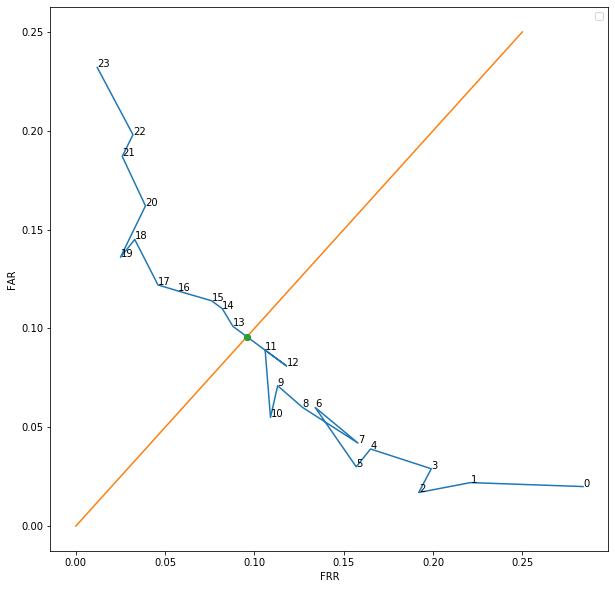

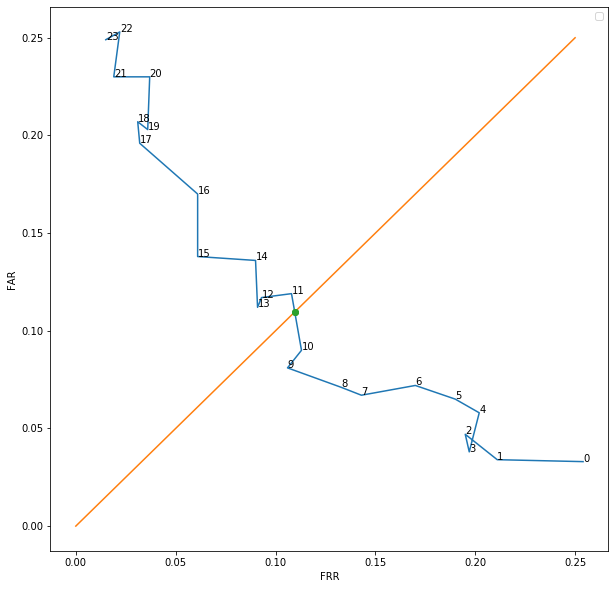

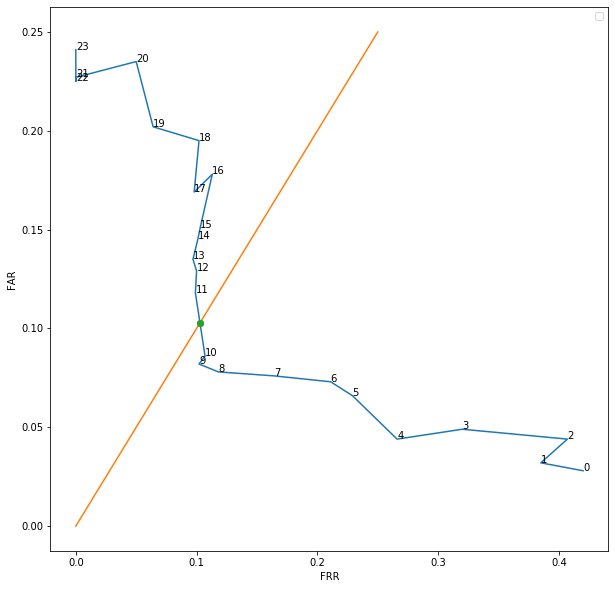

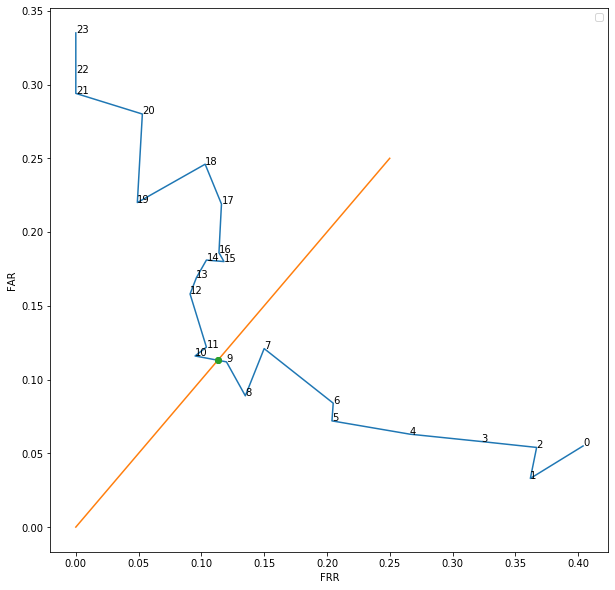

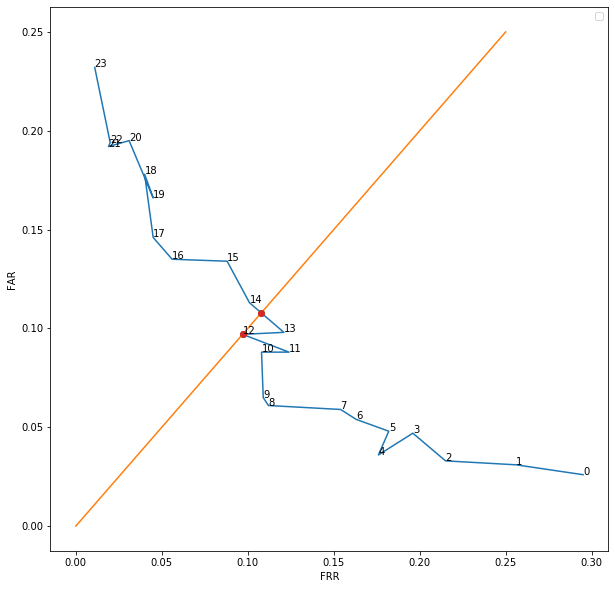

In [98]:
#1. train subject , train subject
counter_true_false_result(0,89,0,89) 

#2. train subject , new subject
counter_true_false_result(0,89, 90,108)

#3. new subject , new subject
counter_true_false_result(90,108, 0,89)

#4. new subject , new subject
counter_true_false_result(90,108, 90,108)

#5. all subject , all subject
counter_true_false_result(0,108, 0,108)